# <span> <center> ANÀLISI DE MAGATZEM </center> </span> 


**Objectiu del codi**: Realitzar l'inventari de quantitat de capses que té cada grup usuari del Biobanc, per tipus de suport.

**Mètode**: Es calcularan el total de capses de cada tipus per cada congelador, i també per cada grup usuari. Com hi ha capses amb diferents capacitats, es tindran en compte les ponderacions del que cada capsa ocupa.

In [7]:
from datetime import date
data = date.today()
data = data.strftime("%d/%m/%Y")

# Per aquesta primera anàlisi es prendrà la data del 31/12/2022:
data = date(2022, 12, 31)
data = data.strftime("%d/%m/%Y")

print("L'últim anàlisi s'ha dut a terme el dia:", data)

L'últim anàlisi s'ha dut a terme el dia: 31/12/2022


## 1. DISSENY I PREPARACIÓ


### NOMENCLATURA
- **Suport**: Al llarg d'aquest script, tractarem com a suport la caixa on van les mostres als congeladors o tancs de nitrogen. Per tant, el total de suports ocupats d'un congelador/tanc implicarà el total de capses amb contingut (alíquotes, normalment) que hi ha en aquest congelador/tanc. El total de suports lliures serà el total de capses sense contingut i amb possibilitat de ser ocupat. Exemple: el suport 9x9 conté fins a 81 alíquotes/mostres.
- **Tipus suport**: El Tipus de suport és el tipus de caixa (Wilmut 0.65, Wilmut 1.4, Gradetes, 9x9). Nosaltres treballarem bàsicament amb els quatre exemples anteriors més les capses de cèl·lules que hi ha als tancs de nitrogen.
- **Ponderació**: Com cada tipus de suport ocupa un espai diferent, ponderarem cada suport segons la seva magnitud per calcular com ubicar de forma més òptima el contingut dels Congeladors/Tancs (Exemple: no ocupa el mateix espai una Wilmut 0.65 que un suport de gradetes). La ponderació serà Wilmut 0.65 = 1, Wilmut 1.4 = 2, 9x9 = 2.55, gradetes = 10.2.
- **Usuari**: Persona/grup d'investigació que sol·licita un servei.
- **Grup usuari**: Grup que efectua un servei i que queda registrat. Exemple: A0-S13006_2805 AGARCIA.
- **Servei**: Acció que s'ofereix a un usuari. Exemple: criopreservació, extracció ADN, congelació...
- **Congelador/Tanc**: També podem anomenar-lo "Equip". És el lloc on van els suports. Exemples: BB01, NL03... 

## 2. IMPORTACIÓ DE DADES

### 2.1. PAQUETS UTILITZATS

In [8]:
# Importem les llibreries que utilitzarem per treballar
# Paquet que permet moltes funcions per a l'anàlisi de dades, com per exemple la descàrrega d'arxius del nostre directori, o diferents operacions amb dataframes.
import pandas as pd

# Paquet que permet realitzar gràfics.
import matplotlib.pyplot as plt

# Paquet per realitzar operacions matemàtiques sobre arrays. 
import numpy as np

# Permet realitzar funcions que depenguin del sistema operatiu.
import os

# Per no mostrar els errors en vermell.
import warnings
warnings.filterwarnings("ignore")

### 2.2. DATAFRAMES

In [9]:
# Utilitzarem l'excel FMULTIPLE.
FMULTIPLE = pd.read_excel("C:/Users/ferra/Downloads/FMULTIPLE.xlsx", 'FMULTIPLE')
# Seleccionem les variables que ens interessen. Creem un dataframe (df) amb aquestes.
FMULTIPLE = FMULTIPLE[['UBICACIO','SERVEI','TIPUS','LABWARE']]

# Mirem els 5 últims casos per comprovar que té sentit (no l'executem per no ensenyar informació de serveis privats).
# FMULTIPLE.tail()

In [10]:
# També criden l'excel d'ubicacions.
UBICACIO = pd.read_excel("C:/Users/ferra/Downloads/FMULTIPLE.xlsx", 'UBIC')
UBIC_TIPUS = pd.read_excel("C:/Users/ferra/Downloads/UBIC_TIPUS.xlsx")
# Mirem els 5 últims casos per comprovar que té sentit. (no l'executem per no ensenyar informació de serveis privats)
# UBIC_TIPUS.tail()

In [11]:
# Juntem UBICACIO amb UBIC_TIPUS (perquè ens surtin els tipus de capsa, els congeladors i els serveis al mateix dataframe)
UBICACIO_df = UBICACIO.merge(UBIC_TIPUS, on="ID_UBIC_TIPUS", how='left')
UBICACIO_df.reset_index(inplace=True, drop=True)
# Mirem si quadra (no l'executem per no ensenyar informació de serveis privats)
# UBICACIO_df

In [12]:
# Juntem UBICACIO_df amb FMULTIPLE per obtenir el dataframe amb tota la informació
magatzem = FMULTIPLE.merge(UBICACIO_df, on="UBICACIO", how='left')

# Mirem si quadra (no l'executem per no ensenyar informació de serveis privats).
# magatzem

# Per guardar el dataframe final com un Excel
#magatzem.to_excel('magatzem_df.xlsx')

## 3. MAGATZEM CONGELADORS I TANCS DE NITROGEN

Volem veure quants suports (línies del dataframe) hi ha a cada congelador/tanc (és a dir, la columna "UBICACIO").
Veiem que molts congeladors/tancs tenen nomenclatura "NOM_número". Volem veure les ocurrències amb el mateix nom, però sense tenir en compte el número/codi després de la barra baixa.

In [13]:
# Hi afegim una nova columna "Congelador/Tanc" que tingui el nom del congelador o tanc de nitrogen sense el número que segueix la barra baixa. 
# Ens quedem, doncs, amb la primera informació que obtinguem (nom del congelador). Per exemple: "CONGELADOR_340" serà "CONGELADOR".
magatzem['Congelador/Tanc'] = magatzem['UBICACIO'].apply(lambda x: x.split('_')[0])

# Abans dels recomptes, juntem els refrigeradors (Congeladors/Tancs) SR1 amb SE1 (per temes interns han de comptar-se junts).
magatzem['Congelador/Tanc'] = magatzem['Congelador/Tanc'].replace(to_replace=['SR1','SE1'],value='SR1+SE1')

# D'aquest dataframe eliminarem les mostres eliminades (que ja no hi són, als refrigeradors).
# A més, treurem els casos de serveis que s'han donat (IP i RECUPERADA PER IP),
# i les mostres que no ens interessen (perquè són neveres, refrigeradors antics, externs o inexistents)
magatzem = magatzem.drop(magatzem[magatzem['UBICACIO'] == "ELIMINADA"].index)
magatzem = magatzem.drop(magatzem[magatzem['UBICACIO'] == "IP"].index)
magatzem = magatzem.drop(magatzem[magatzem['UBICACIO'] == "RECUPERADA PER IP"].index)
magatzem = magatzem.drop(magatzem[magatzem['UBICACIO'] == "PENDENT INVENTARI"].index)
magatzem = magatzem.drop(magatzem[magatzem['UBICACIO'] == "Congelador -20ºC"].index)
magatzem = magatzem.drop(magatzem[magatzem['UBICACIO'] == "Congelador -20ºC aDNA"].index)
magatzem = magatzem.drop(magatzem[magatzem['UBICACIO'] == "Nevera 4ºC aDNA"].index)
magatzem = magatzem.drop(magatzem[magatzem['UBICACIO'] == "Nevera 4ºC Cultius"].index)
magatzem = magatzem.drop(magatzem[magatzem['UBICACIO'] == "Primer Envío MATER"].index)
magatzem = magatzem.drop(magatzem[magatzem['UBICACIO'] == "EN TRÀNSIT PER CESSIÓ"].index)
magatzem = magatzem.drop(magatzem[magatzem['UBICACIO'] == "TRÀNSIT"].index)
magatzem = magatzem.drop(magatzem[magatzem['UBICACIO'] == "Mostres reubicades a microplaca nova."].index)

# Treiem suports que no inclourem
magatzem = magatzem.drop(magatzem[magatzem['UBIC_TIPUS'] == "PREDICT-Safata especial (9x9+micronic gran)"].index)

# Treiem refrigeradors que no cal que surtin al anàlisi (perquè són neveres o congeladors back-up)
magatzem = magatzem.drop(magatzem[magatzem['Congelador/Tanc'] == "NE1"].index)
magatzem = magatzem.drop(magatzem[magatzem['Congelador/Tanc'] == "NE2"].index)
magatzem = magatzem.drop(magatzem[magatzem['Congelador/Tanc'] == "NE3"].index)
magatzem = magatzem.drop(magatzem[magatzem['Congelador/Tanc'] == "LOG06"].index)

# Creem una columna amb els noms de les línies d'investigació pseudonimitzades.
# La pseudonimització es farà adjudicant un codi de tipus "SA0-número" a cada línia d'investigació A0, en un full de dades extern.
magatzem['Línia A0'] = magatzem['SERVEI']
SA0_ANON = pd.read_excel("C:/Users/ferra/Downloads/serveis a3 a0 anon.xlsx",'A0', header=0)
# Juntem els noms dels serveis al dataframe original amb el dels codis d'anonimització.
magatzem = pd.merge(magatzem, SA0_ANON, on="Línia A0")

# Ens queda el dataframe més net. 
# magatzem.tail(5)

# Per guardar el dataframe com un Excel
# magatzem.to_excel('magatzem2_df.xlsx')

In [14]:
# Anotem els noms complets de cada congelador (cada congelador té tres noms diferents: el curt, el llarg i el que especifica el contingut)
magatzem['Nom congelador/tanc'] = magatzem['Congelador/Tanc'].replace(
            'DN2','S-101 (DNA2)').replace(
            'SR1+SE1','S-102 (Serveis 1)').replace(
            'DN1','S-104 (DNA1)').replace(
            'SR2','S-105 (Serveis 2) Diabetis').replace(
            'BB01','S-106').replace(
            'SM2','S-107 (Sèrum 2)').replace(
            'PL2','S-110 (Plasma 2)').replace(
            'SM1','S-111 (Sèrum 1 trànsit)').replace(
            'SR4','S-114 (Canònic)').replace(
            'PL1','S-115 (Plasma 1)').replace(
            'SR3','S-116 (Seroteca)').replace(
            'LOG01','BBLOG01').replace(
            'LOG03','BBLOG03').replace(
            'LOG04','BBLOG04').replace(
            'COV','S-103 (COV suport)').replace(
            'DNM','S-108 (DNA mare)').replace(
            'LOG05','S-125 (MIG, safates C i D)')

### 3.1. TIPUS DE SUPORT OCUPAT PER CONGELADOR/TANC (AGRUPANT ELS TIPUS)

Agruparem els tipus de suport en Wilmut 0.65, Wilmut 1.4, gradetes, 9x9, etc, per unificar capacitats d'espai. Per exemple, les capses "CRIOBOX Nitrogen 10x10" són capses de "Tanc Nitrogen" mentres que les "Gradetes tubs 5x12" pertanyen al grup de "Gradetes".

In [15]:
# Per a fer-ho, utilitzarem un "replace" de noms, segons l'excel "Recomptes Controls".
# Ho afegim a una nova columna.
magatzem['Tipus suport'] = magatzem['UBIC_TIPUS'].replace(
            'CRIOBOX Nitrogen 10x10','Tanc Nitrogen').replace(
            'Altres','Gradetes').replace(
            'Calaix per CAIXES 9x9 (-80ºC)','9x9').replace(
            'Calaix CAIXES ALTES 9x9 (-80ºC)','9x9').replace(
            'Calaix ample per microplaques (-80ºC)','Wilmut 0.65').replace(
            'Calaix estret per microplaques (-80ºC)','Wilmut 0.65').replace(
            'Calaix per microplaques grans 1,4ml (-80ºC)','Wilmut 1.4').replace(
            'Estant per Gradetes 10x4','Gradetes').replace(
            'Gradetes tubs 4 posiciones','Gradetes').replace(
            'Gradetes tubs 5x12','Gradetes').replace(
            'Gradetes tubs 6 posiciones','Gradetes').replace(
            'Envíos MII','Gradetes').replace(
            'Caixa NE1 4ºC per microplaques','Wilmut 0.65')
# Podem visualitzar els últims casos per comprovar que tot està en ordre.
#magatzem.tail()

In [16]:
# Recompte de suports per refrigerador i per tipus de suport conjunt:
refrigerador_tipussuport = magatzem.groupby(['Congelador/Tanc','Tipus suport']).count()

# Com surten tres columnes al recompte, prenem una qualsevol i li canviem el nom:
refrigerador_tipussuport = pd.DataFrame(refrigerador_tipussuport['UBICACIO'])
refrigerador_tipussuport.columns = ['Recompte']
refrigerador_tipussuport

# GUARDAR INFORMACIÓ
# Només cal canviar el directori i el nom de l'arxiu.
#refrigerador_tipussuport.to_excel('congelador-suport_DES2022.xlsx')

Recompte
Congelador/Tanc Tipus suport           
BB01            Wilmut 0.65        1040
COV             9x9                 102
                Gradetes              4
                Wilmut 0.65         510
DN1             Wilmut 0.65         689
DN2             Wilmut 0.65         866
DNM             Gradetes             15
                Wilmut 1.4          293
LOG01           9x9                 178
                Gradetes             40
                Wilmut 0.65          27
                Wilmut 1.4           11
LOG03           9x9                 203
                Gradetes             19
LOG04           9x9                  67
                Gradetes             18
                Wilmut 0.65         165
LOG05           Gradetes             23
NL1             Tanc Nitrogen       730
NL2             Tanc Nitrogen       721
NL3             Tanc Nitrogen       125
NL4             Tanc Nitrogen       711
NL5             Tanc Nitrogen       128
PL1             Wilmut 0.65        1055
                Wilmut 1.4          108
PL2             Wilmut 0.65         768
PRE01           Wilmut 0.65        1293
PRE02           9x9                  16
                Gradetes            156
PRE03           Gradetes             64
                Wilmut 0.65         526
PRE04           9x9                  80
                Gradetes             77
SM1             Wilmut 0.65         624
SM2             Wilmut 0.65        1124
SR1+SE1         9x9                 365
                Wilmut 0.65           9
                Wilmut 1.4           79
SR2             9x9                  78
                Wilmut 0.65         405
SR3             9x9                 347
                Wilmut 0.65          38
SR4             9x9                 132
                Gradetes             25
                Wilmut 0.65         139

In [17]:
# Recompte de suports pel tipus de suport conjunt i refrigerador: 
tipussuport_refrigerador = magatzem.groupby(['Tipus suport','Congelador/Tanc']).count()
# Com surten vàries columnes al recompte, prenem una qualsevol i li canviem el nom:
tipussuport_refrigerador = pd.DataFrame(tipussuport_refrigerador['UBICACIO'])
tipussuport_refrigerador.columns = ['Recompte']
tipussuport_refrigerador

# GUARDAR INFORMACIÓ
# Només cal canviar el directori i el nom de l'arxiu.
#tipussuport_refrigerador.to_excel('suport-congelador_DES2022.xlsx')

Recompte
Tipus suport  Congelador/Tanc          
9x9           COV                   102
              LOG01                 178
              LOG03                 203
              LOG04                  67
              PRE02                  16
              PRE04                  80
              SR1+SE1               365
              SR2                    78
              SR3                   347
              SR4                   132
Gradetes      COV                     4
              DNM                    15
              LOG01                  40
              LOG03                  19
              LOG04                  18
              LOG05                  23
              PRE02                 156
              PRE03                  64
              PRE04                  77
              SR4                    25
Tanc Nitrogen NL1                   730
              NL2                   721
              NL3                   125
              NL4                   711
              NL5                   128
Wilmut 0.65   BB01                 1040
              COV                   510
              DN1                   689
              DN2                   866
              LOG01                  27
              LOG04                 165
              PL1                  1055
              PL2                   768
              PRE01                1293
              PRE03                 526
              SM1                   624
              SM2                  1124
              SR1+SE1                 9
              SR2                   405
              SR3                    38
              SR4                   139
Wilmut 1.4    DNM                   293
              LOG01                  11
              PL1                   108
              SR1+SE1                79

### 3.2. SUPORTS DISPONIBLES, OCUPATS I TOTALS PER CONGELADOR/TANC

Inclouen els tancs de nitrogen i capses PREDICT.

In [18]:
# PER TIPUS DE SUPORT
# Tornem a fer el recompte com abans:
total_ocu_disp = tipussuport_refrigerador
total_ocu_disp.columns = ['Capacitat ocupació']

# Creem una columna buida on només hi inclourem la capacitat màxima de cada Congelador/Tanc per cada tipus.
total_ocu_disp['Capacitat màxima'] = 0

# Anotem les capacitats màximes de cada Congelador/Tanc a mà en funció de la configuració (comunicada per part de l'equip tècnic):

# DN2
max_DN2_wilmut05 = total_ocu_disp['Capacitat màxima'].loc['Wilmut 0.65','DN2'] = 960

# SR1+SE1
max_SR1SE1_wilmut05 = total_ocu_disp['Capacitat màxima'].loc['Wilmut 0.65','SR1+SE1'] = 9
max_SR1SE1_wilmut14 = total_ocu_disp['Capacitat màxima'].loc['Wilmut 1.4','SR1+SE1'] = 91
max_SR1SE1_9x9 = total_ocu_disp['Capacitat màxima'].loc['9x9','SR1+SE1'] = 416

# DN1
max_DN1_wilmut05 = total_ocu_disp['Capacitat màxima'].loc['Wilmut 0.65','DN1'] = 816

# SR2
max_SR2_wilmut05 = total_ocu_disp['Capacitat màxima'].loc['Wilmut 0.65','SR2'] = 600
max_SR2_9x9 = total_ocu_disp['Capacitat màxima'].loc['9x9','SR2'] = 80

# BB01
max_BB01_wilmut05 = total_ocu_disp['Capacitat màxima'].loc['Wilmut 0.65','BB01'] = 1156 # Abans era 1110 (canviat Ada: 12/04/23)

# SM2
max_SM2_wilmut05 = total_ocu_disp['Capacitat màxima'].loc['Wilmut 0.65','SM2'] = 1152

# DNM
max_DNM_wilmut14 = total_ocu_disp['Capacitat màxima'].loc['Wilmut 1.4','DNM'] = 294
max_DNM_gradetes = total_ocu_disp['Capacitat màxima'].loc['Gradetes','DNM'] = 15
max_DNM_9x9 = total_ocu_disp['Capacitat màxima'].loc['9x9','DNM'] = 4

# PL2
max_PL2_wilmut05 = total_ocu_disp['Capacitat màxima'].loc['Wilmut 0.65','PL2'] = 768

# SM1
max_SM1_wilmut05 = total_ocu_disp['Capacitat màxima'].loc['Wilmut 0.65','SM1'] = 624
max_SM1_gradetes = total_ocu_disp['Capacitat màxima'].loc['Gradetes','SM1'] = 12 # Abans era havia 0 (canviat Ada: 12/04/23)

# SR4
max_SR4_wilmut05 = total_ocu_disp['Capacitat màxima'].loc['Wilmut 0.65','SR4'] = 390
max_SR4_gradetes = total_ocu_disp['Capacitat màxima'].loc['Gradetes','SR4'] = 28
max_SR4_9x9 = total_ocu_disp['Capacitat màxima'].loc['9x9','SR4'] = 200

# PL1
max_PL1_wilmut05 = total_ocu_disp['Capacitat màxima'].loc['Wilmut 0.65','PL1'] = 1056
max_PL1_wilmut14 = total_ocu_disp['Capacitat màxima'].loc['Wilmut 1.4','PL1'] = 108

# SR3
max_SR3_wilmut05 = total_ocu_disp['Capacitat màxima'].loc['Wilmut 0.65','SR3'] = 118
max_SR3_9x9 = total_ocu_disp['Capacitat màxima'].loc['9x9','SR3'] = 404

# LOG01
max_LOG01_wilmut05 = total_ocu_disp['Capacitat màxima'].loc['Wilmut 0.65','LOG01'] = 144
max_LOG01_wilmut14 = total_ocu_disp['Capacitat màxima'].loc['Wilmut 1.4','LOG01'] = 12
max_LOG01_gradetes = total_ocu_disp['Capacitat màxima'].loc['Gradetes','LOG01'] = 40
max_LOG01_9x9 = total_ocu_disp['Capacitat màxima'].loc['9x9','LOG01'] = 204

# LOG03
max_LOG03_gradetes = total_ocu_disp['Capacitat màxima'].loc['Gradetes','LOG03'] = 20
max_LOG03_9x9 = total_ocu_disp['Capacitat màxima'].loc['9x9','LOG03'] = 240

# LOG04
max_LOG04_wilmut05 = total_ocu_disp['Capacitat màxima'].loc['Wilmut 0.65','LOG04'] = 400
max_LOG04_gradetes = total_ocu_disp['Capacitat màxima'].loc['Gradetes','LOG04'] = 21 # Abans era havia 18 (canviat Ada: 12/04/23)
max_LOG04_9x9 = total_ocu_disp['Capacitat màxima'].loc['9x9','LOG04'] = 72

# LOG05
max_LOG05_gradetes = total_ocu_disp['Capacitat màxima'].loc['Gradetes','LOG05'] = 30 # Abans era havia 23 (canviat Ada: 12/04/23)
max_LOG05_9x9 = total_ocu_disp['Capacitat màxima'].loc['9x9','LOG05'] = 80

# COV
max_COV_wilmut05 = total_ocu_disp['Capacitat màxima'].loc['Wilmut 0.65','COV'] = 672
max_COV_gradetes = total_ocu_disp['Capacitat màxima'].loc['Gradetes','COV'] = 6 # Abans era havia 4 (canviat Ada: 12/04/23)
max_COV_9x9 = total_ocu_disp['Capacitat màxima'].loc['9x9','COV'] = 120

# NL1
max_NL1_tancnitrogen = total_ocu_disp['Capacitat màxima'].loc['Tanc Nitrogen','NL1'] = 730

# NL2
max_NL2_tancnitrogen = total_ocu_disp['Capacitat màxima'].loc['Tanc Nitrogen','NL2'] = 720

# NL3
max_NL3_tancnitrogen = total_ocu_disp['Capacitat màxima'].loc['Tanc Nitrogen','NL3'] = 720

# NL4
max_NL4_tancnitrogen = total_ocu_disp['Capacitat màxima'].loc['Tanc Nitrogen','NL4'] = 720

# NL5
max_NL5_tancnitrogen = total_ocu_disp['Capacitat màxima'].loc['Tanc Nitrogen','NL5'] = 720

# PRE01
max_PRE01_wilmut05 = total_ocu_disp['Capacitat màxima'].loc['Wilmut 0.65','PRE01'] = 1294

# PRE02
max_PRE02_wilmut05 = total_ocu_disp['Capacitat màxima'].loc['Wilmut 0.65','PRE02'] = 9
max_PRE02_wilmut14 = total_ocu_disp['Capacitat màxima'].loc['Wilmut 1.4','PRE02'] = 91
max_PRE02_gradetes = total_ocu_disp['Capacitat màxima'].loc['Gradetes','PRE02'] = 148
max_PRE02_9x9 = total_ocu_disp['Capacitat màxima'].loc['9x9','PRE02'] = 416

# PRE03
max_PRE03_wilmut05 = total_ocu_disp['Capacitat màxima'].loc['Wilmut 0.65','PRE03'] = 816
max_PRE03_gradetes = total_ocu_disp['Capacitat màxima'].loc['Gradetes','PRE03'] = 70

# PRE04
max_PRE04_gradetes = total_ocu_disp['Capacitat màxima'].loc['Gradetes','PRE04'] = 83
max_PRE04_9x9 = total_ocu_disp['Capacitat màxima'].loc['9x9','PRE04'] = 80

# Per calcular els suports lliures, fem la resta dels suports de capacitat màxima menys els suports ocupats.
total_ocu_disp['Capacitat lliure'] = total_ocu_disp['Capacitat màxima'] - total_ocu_disp['Capacitat ocupació']

# Movem la columna de capacitat màxima perquè estigui al principi i sigui més visual.
# La posem al prinicipi (0) (si volguessim al final, seria 2))
columna_a_moure = total_ocu_disp.pop('Capacitat màxima')
total_ocu_disp.insert(0, 'Capacitat màxima', columna_a_moure)

# AMB PREDICT I TANCS NITROGEN
#total_ocu_disp

# GUARDAR INFORMACIÓ
# Només cal canviar el directori i el nom de l'arxiu.
## total_ocu_disp.to_excel(r'C:/Users/FLUGO.HCP/Downloads/Recompte Magatzem - Tipussuport-Congelador/Tanc-SuportMàxims-ocupats-lliures.xlsx', index=True)

In [19]:
# Afegim les ubicacions buides, que no surten en el recompte anterior.
# Treiem els índexs per passar de "recomptes" a "dataframe".
total_ocu_disp_df2 = total_ocu_disp.reset_index()
new_row = {'Tipus suport':'9x9', 'Congelador/Tanc':'DNM', 'Capacitat màxima': max_DNM_9x9, 'Capacitat ocupació':0, 'Capacitat lliure': max_DNM_9x9}
new_row2 = {'Tipus suport':'9x9', 'Congelador/Tanc':'LOG05', 'Capacitat màxima': max_LOG05_9x9, 'Capacitat ocupació':0, 'Capacitat lliure': max_LOG05_9x9}
new_row3 = {'Tipus suport':'Gradetes', 'Congelador/Tanc':'SM1', 'Capacitat màxima': max_SM1_gradetes, 'Capacitat ocupació':0, 'Capacitat lliure': max_SM1_gradetes}

# Afegim ubicacions buides:
df2 = total_ocu_disp_df2.append(new_row, ignore_index=True)
df2 = df2.append(new_row2, ignore_index=True)
df2 = df2.append(new_row3, ignore_index=True)
df2 = df2.set_index("Tipus suport")

# Ordenem per suports
df2 = df2.sort_index()
df2

,Congelador/Tanc,Capacitat màxima,Capacitat ocupació,Capacitat lliure
Tipus suport,,,,
9x9,COV,120,102,18
9x9,LOG01,204,178,26
9x9,LOG03,240,203,37
9x9,LOG04,72,67,5
9x9,PRE02,416,16,400
9x9,PRE04,80,80,0
9x9,SR1+SE1,416,365,51
9x9,SR2,80,78,2
9x9,SR3,404,347,57


In [20]:
# Afegim informació a la taula
# Per cada congelador, anotarem la capacitat màxima.
total_ocu_disp2 = refrigerador_tipussuport
#total_ocu_disp2.columns = ['Capacitat ocupació']
total_ocu_disp2['Capacitat màxima'] = 0
total_ocu_disp2['Capacitat màxima'].loc['DN2','Wilmut 0.65'] = max_DN2_wilmut05
total_ocu_disp2['Capacitat màxima'].loc['SR1+SE1','Wilmut 0.65'] = max_SR1SE1_wilmut05
total_ocu_disp2['Capacitat màxima'].loc['SR1+SE1','Wilmut 1.4'] = max_SR1SE1_wilmut14
total_ocu_disp2['Capacitat màxima'].loc['SR1+SE1','9x9'] = max_SR1SE1_9x9
total_ocu_disp2['Capacitat màxima'].loc['DN1','Wilmut 0.65'] = max_DN1_wilmut05
total_ocu_disp2['Capacitat màxima'].loc['SR2','Wilmut 0.65'] = max_SR2_wilmut05
total_ocu_disp2['Capacitat màxima'].loc['SR2','9x9'] = max_SR2_9x9
total_ocu_disp2['Capacitat màxima'].loc['BB01','Wilmut 0.65'] = max_BB01_wilmut05
total_ocu_disp2['Capacitat màxima'].loc['SM2','Wilmut 0.65'] = max_SM2_wilmut05
total_ocu_disp2['Capacitat màxima'].loc['DNM','Wilmut 1.4'] = max_DNM_wilmut14
total_ocu_disp2['Capacitat màxima'].loc['DNM','Gradetes'] = max_DNM_gradetes
total_ocu_disp2['Capacitat màxima'].loc['DNM','9x9'] = max_DNM_9x9
total_ocu_disp2['Capacitat màxima'].loc['PL2','Wilmut 0.65'] = max_PL2_wilmut05
total_ocu_disp2['Capacitat màxima'].loc['SM1','Wilmut 0.65'] = max_SM1_wilmut05
total_ocu_disp2['Capacitat màxima'].loc['SR4','Wilmut 0.65'] = max_SR4_wilmut05 
total_ocu_disp2['Capacitat màxima'].loc['SR4','Gradetes'] = max_SR4_gradetes
total_ocu_disp2['Capacitat màxima'].loc['SR4','9x9'] = max_SR4_9x9 
total_ocu_disp2['Capacitat màxima'].loc['PL1','Wilmut 0.65'] = max_PL1_wilmut05
total_ocu_disp2['Capacitat màxima'].loc['PL1','Wilmut 1.4'] = max_PL1_wilmut14
total_ocu_disp2['Capacitat màxima'].loc['SR3','Wilmut 0.65'] = max_SR3_wilmut05 
total_ocu_disp2['Capacitat màxima'].loc['SR3','9x9'] = max_SR3_9x9
total_ocu_disp2['Capacitat màxima'].loc['LOG01','Wilmut 0.65'] = max_LOG01_wilmut05
total_ocu_disp2['Capacitat màxima'].loc['LOG01','Wilmut 1.4'] = max_LOG01_wilmut14 
total_ocu_disp2['Capacitat màxima'].loc['LOG01','Gradetes'] = max_LOG01_gradetes
total_ocu_disp2['Capacitat màxima'].loc['LOG01','9x9'] = max_LOG01_9x9
total_ocu_disp2['Capacitat màxima'].loc['LOG03','Gradetes'] = max_LOG03_gradetes
total_ocu_disp2['Capacitat màxima'].loc['LOG03','9x9'] = max_LOG03_9x9
total_ocu_disp2['Capacitat màxima'].loc['LOG04','Wilmut 0.65'] = max_LOG04_wilmut05
total_ocu_disp2['Capacitat màxima'].loc['LOG04','Gradetes'] = max_LOG04_gradetes
total_ocu_disp2['Capacitat màxima'].loc['LOG04','9x9'] = max_LOG04_9x9
total_ocu_disp2['Capacitat màxima'].loc['LOG05','Gradetes'] = max_LOG05_gradetes
total_ocu_disp2['Capacitat màxima'].loc['LOG05','9x9'] = max_LOG05_9x9
total_ocu_disp2['Capacitat màxima'].loc['COV','Wilmut 0.65'] = max_COV_wilmut05
total_ocu_disp2['Capacitat màxima'].loc['COV','Gradetes'] = max_COV_gradetes
total_ocu_disp2['Capacitat màxima'].loc['COV','9x9'] = max_COV_9x9
total_ocu_disp2['Capacitat màxima'].loc['NL1','Tanc Nitrogen'] = max_NL1_tancnitrogen
total_ocu_disp2['Capacitat màxima'].loc['NL2','Tanc Nitrogen'] = max_NL2_tancnitrogen
total_ocu_disp2['Capacitat màxima'].loc['NL3','Tanc Nitrogen'] = max_NL3_tancnitrogen
total_ocu_disp2['Capacitat màxima'].loc['NL4','Tanc Nitrogen'] = max_NL4_tancnitrogen
total_ocu_disp2['Capacitat màxima'].loc['NL5','Tanc Nitrogen'] = max_NL5_tancnitrogen
total_ocu_disp2['Capacitat màxima'].loc['PRE01','Wilmut 0.65'] = max_PRE01_wilmut05
total_ocu_disp2['Capacitat màxima'].loc['PRE02','Wilmut 0.65'] = max_PRE02_wilmut05 
total_ocu_disp2['Capacitat màxima'].loc['PRE02','Wilmut 1.4'] = max_PRE02_wilmut14
total_ocu_disp2['Capacitat màxima'].loc['PRE02','Gradetes'] = max_PRE02_gradetes
total_ocu_disp2['Capacitat màxima'].loc['PRE02','9x9'] = max_PRE02_9x9 
total_ocu_disp2['Capacitat màxima'].loc['PRE03','Wilmut 0.65'] = max_PRE03_wilmut05
total_ocu_disp2['Capacitat màxima'].loc['PRE03','Gradetes'] = max_PRE03_gradetes
total_ocu_disp2['Capacitat màxima'].loc['PRE04','Gradetes'] = max_PRE04_gradetes
total_ocu_disp2['Capacitat màxima'].loc['PRE04','9x9'] = max_PRE04_9x9

# Com abans, afegim les ubicacions buides, que no surten en el recompte anterior.
# Per a fer-ho, treiem primer l'índex i passar de "recomptes" a "dataframe".
total_ocu_disp_df2 = total_ocu_disp.reset_index()
new_row = {'Tipus suport':'9x9', 'Congelador/Tanc':'DNM', 'Capacitat màxima': max_DNM_9x9, 'Capacitat ocupació':0, 'Capacitat lliure': max_DNM_9x9}
new_row2 = {'Tipus suport':'9x9', 'Congelador/Tanc':'LOG05', 'Capacitat màxima': max_LOG05_9x9, 'Capacitat ocupació':0, 'Capacitat lliure': max_LOG05_9x9}
new_row3 = {'Tipus suport':'Gradetes', 'Congelador/Tanc':'SM1', 'Capacitat màxima': max_SM1_gradetes, 'Capacitat ocupació':0, 'Capacitat lliure': max_SM1_gradetes}

# Afegim ubicacions buides:
total_ocu_disp_df2 = total_ocu_disp_df2.append(new_row, ignore_index=True)
total_ocu_disp_df2 = total_ocu_disp_df2.append(new_row2, ignore_index=True)
total_ocu_disp_df2 = total_ocu_disp_df2.append(new_row3, ignore_index=True)
total_ocu_disp_df2 = total_ocu_disp_df2.set_index("Congelador/Tanc")
# Ordenem per suports
total_ocu_disp2 = total_ocu_disp_df2.sort_index()

# Per calcular els suports lliures, fem la resta dels suports de capacitat màxima menys els suports ocupats.
total_ocu_disp2['Capacitat lliure'] = total_ocu_disp2['Capacitat màxima'] - total_ocu_disp2['Capacitat ocupació']

# Movem la columna de capacitat màxima perquè estigui al principi i sigui més visual. La posem al prinicipi (0) (si volguessim al final, seria 2))
#columna_a_moure2 = total_ocu_disp2.pop('Capacitat màxima')
#total_ocu_disp2.insert(0, 'Capacitat màxima', columna_a_moure2)

# Després de la reunió del 04/10/22 volem afegir els percentatges d'espai lliure de cada congelador/tanc de nitrogen:
total_ocu_disp2['% Capacitat lliure'] = total_ocu_disp2['Capacitat lliure']/total_ocu_disp2['Capacitat màxima']*100

# PONDERACIÓ
# Finalment, ponderem l'espai ocupat.
total_ocu_disp2['Ponderació'] = total_ocu_disp2['Tipus suport']
total_ocu_disp2['Ponderació'] = total_ocu_disp2['Ponderació'].replace('Wilmut 0.65',1).replace('Wilmut 1.4',2).replace('9x9',2.55).replace('Gradetes',10.2).replace('Tanc Nitrogen',0)
          
# RECOMPTE PONDERAT
# Creem columna pel recompte ponderat:
total_ocu_disp2['Total ponderat']= total_ocu_disp2['Capacitat màxima']*total_ocu_disp2['Ponderació']
total_ocu_disp2['Lliure ponderat']= total_ocu_disp2['Capacitat lliure']*total_ocu_disp2['Ponderació']

# AMB PREDICT I TANCS NITROGEN
total_ocu_disp2

# GUARDAR INFORMACIÓ
# Només cal canviar el directori i el nom de l'arxiu.
#total_ocu_disp2.to_excel('congelador-maxmin_DES2022.xlsx')

,Tipus suport,Capacitat màxima,Capacitat ocupació,Capacitat lliure,% Capacitat lliure,Ponderació,Total ponderat,Lliure ponderat
Congelador/Tanc,,,,,,,,
BB01,Wilmut 0.65,1156,1040,116,10.034602,1.00,1156.0,116.00
COV,9x9,120,102,18,15.000000,2.55,306.0,45.90
COV,Wilmut 0.65,672,510,162,24.107143,1.00,672.0,162.00
COV,Gradetes,6,4,2,33.333333,10.20,61.2,20.40
DN1,Wilmut 0.65,816,689,127,15.563725,1.00,816.0,127.00
DN2,Wilmut 0.65,960,866,94,9.791667,1.00,960.0,94.00
DNM,Gradetes,15,15,0,0.000000,10.20,153.0,0.00
DNM,9x9,4,0,4,100.000000,2.55,10.2,10.20
DNM,Wilmut 1.4,294,293,1,0.340136,2.00,588.0,2.00


### 3.3. TAULA RESUM

Suports TOTALS, OCUPATS i LLIURES de de cada tipus. 

**Aquí NO s'inclouran els congeladors PREDICT ni els Tancs de Nitrogen!** (per petició de Coordinació)

Els suports ponderats lliures no són excloents ni complementaris (és a dir, es pot anar modificant segons convingui i segons la capacitat màxima total). Així, es poden fer combinacions. Per exemple, si hi ha 10 Wilmut 0.65 disponibles (ocupen 1) potser ens interessa posar 4 Wilmuts 1.4 (ocupen 2.55) en comptes d'això. Per tant, **si capacitat màxima canvia, canviarà tot**. 

In [21]:
# Treiem els congeladors de predict i els tancs de nitrogen.
NOpredict = total_ocu_disp2.drop("PRE01")
NOpredict = NOpredict.drop("PRE02")
NOpredict = NOpredict.drop("PRE03")
NOpredict = NOpredict.drop("PRE04")
NOpredict = NOpredict.drop("NL1")
NOpredict = NOpredict.drop("NL2")
NOpredict = NOpredict.drop("NL3")
NOpredict = NOpredict.drop("NL4")
NOpredict = NOpredict.drop("NL5")
NOpredict = NOpredict.reset_index()
NOpredict = NOpredict.set_index(['Congelador/Tanc', 'Tipus suport'])

In [22]:
# Canviem l'índex al tipus de suport.
NOpredict = NOpredict.reset_index()
NOpredict = NOpredict.set_index("Tipus suport")

# RECOMPTES DE CADA TIPUS (SENSE PREDICT)
# Wilmut 0.65
totals_wilmut05 = NOpredict['Capacitat màxima'].loc['Wilmut 0.65'].sum()
ocupats_wilmut05 = NOpredict['Capacitat ocupació'].loc['Wilmut 0.65'].sum()
lliures_wilmut05 = NOpredict['Capacitat lliure'].loc['Wilmut 0.65'].sum()

# Wilmut 1.4
totals_wilmut14 = NOpredict['Capacitat màxima'].loc['Wilmut 1.4'].sum()
ocupats_wilmut14 = NOpredict['Capacitat ocupació'].loc['Wilmut 1.4'].sum()
lliures_wilmut14 = NOpredict['Capacitat lliure'].loc['Wilmut 1.4'].sum()

# Gradetes
totals_gradetes = NOpredict['Capacitat màxima'].loc['Gradetes'].sum()
ocupats_gradetes = NOpredict['Capacitat ocupació'].loc['Gradetes'].sum()
lliures_gradetes = NOpredict['Capacitat lliure'].loc['Gradetes'].sum()

# 9x9
totals_9x9 = NOpredict['Capacitat màxima'].loc['9x9'].sum()
ocupats_9x9 = NOpredict['Capacitat ocupació'].loc['9x9'].sum()
lliures_9x9 = NOpredict['Capacitat lliure'].loc['9x9'].sum()

# Creem la taula resum amb els recomptes.
taula_resum_tipus = {
    'Tipus suport' : ['Wilmut 0.65', 'Wilmut 1.4', 'Gradetes','9x9'],
    'Totals': [totals_wilmut05, totals_wilmut14 , totals_gradetes, totals_9x9],
    'Ocupats': [ocupats_wilmut05, ocupats_wilmut14, ocupats_gradetes, ocupats_9x9],
    'Lliures': [lliures_wilmut05, lliures_wilmut14, lliures_gradetes, lliures_9x9],
}

# Fem de la taula un dataframe i posem com a índex de variables el tipus de suport.
taula_resum_tipus = pd.DataFrame(taula_resum_tipus)
taula_resum_tipus = taula_resum_tipus.set_index('Tipus suport')

# PERCENTATGES
# No els executem, però es poden calcular. Serien percentatges de suport lliures dins de cada congelador:
#taula_resum_tipus['% lliures'] = taula_resum_tipus['Lliures']/taula_resum_tipus['Totals']*100


# PONDERACIÓ
# Afegim els suports totals i lliures ponderats:
total_wilmut05 = taula_resum_tipus.loc['Wilmut 0.65']
to1 = total_wilmut05['Totals']*1
oc1 = total_wilmut05['Ocupats']*1
ll1 = total_wilmut05['Lliures']*1

total_wilmut14 = taula_resum_tipus.loc['Wilmut 1.4']
to2 = total_wilmut14['Totals']*2
oc2 = total_wilmut14['Ocupats']*2
ll2 = total_wilmut14['Lliures']*2

total_gradetes = taula_resum_tipus.loc['Gradetes']
to3 = total_gradetes['Totals']*10.2
oc3 = total_gradetes['Ocupats']*10.2
ll3 = total_gradetes['Lliures']*10.2

total_9x9 = taula_resum_tipus.loc['9x9']
to4 = total_9x9['Totals']*2.55
oc4 = total_9x9['Ocupats']*2.55
ll4 = total_9x9['Lliures']*2.55

# Acabem la taula resum
taula_resum_tipus['Totals pond'] = [to1,to2,to3,to4]
taula_resum_tipus['Ocupats pond'] = [oc1,oc2,oc3,oc4]
taula_resum_tipus['Lliures pond'] = [ll1,ll2,ll3,ll4]

# Afegim els total i els % ponderat
taula_resum_tipus.loc['TOTAL',:]= taula_resum_tipus.sum(axis=0)

# TAULA RESUM SENSE PREDICT
taula_resum_tipus

# GUARDAR INFORMACIÓ
# Només cal canviar el directori i el nom de l'arxiu.
#taula_resum_tipus.to_excel('taularesum.xlsx')

,Totals,Ocupats,Lliures,Totals pond,Ocupats pond,Lliures pond
Tipus suport,,,,,,
Wilmut 0.65,8865.0,7459.0,1406.0,8865.0,7459.0,1406.0
Wilmut 1.4,505.0,491.0,14.0,1010.0,982.0,28.0
Gradetes,172.0,144.0,28.0,1754.4,1468.8,285.6
9x9,1820.0,1472.0,348.0,4641.0,3753.6,887.4
TOTAL,11362.0,9566.0,1796.0,16270.4,13663.4,2607.0


### TANCS DE NITROGEN

Fem la taula resum amb únicament els tancs de nitrogen.

In [23]:
total_ocu_disp_TN = total_ocu_disp2.loc[total_ocu_disp2["Tipus suport"] == "Tanc Nitrogen"]
total_ocu_disp_TN = total_ocu_disp_TN[total_ocu_disp_TN.columns[:-3]]
total_ocu_disp_TN.loc['TOTAL',:]= total_ocu_disp_TN.sum(axis=0)
# Borrem la primera columna (que anota que són tancs de nitrogen)
total_ocu_disp_TN = total_ocu_disp_TN.iloc[: , 1:]
total_ocu_disp_TN

# GUARDAR INFORMACIÓ
# Només cal canviar el directori i el nom de l'arxiu.
#total_ocu_disp_TN.to_excel('taularesum_nitrogen.xlsx')

,Capacitat màxima,Capacitat ocupació,Capacitat lliure,% Capacitat lliure
Congelador/Tanc,,,,
NL1,730.0,730.0,0.0,0.000000
NL2,720.0,721.0,-1.0,-0.138889
NL3,720.0,125.0,595.0,82.638889
NL4,720.0,711.0,9.0,1.250000
NL5,720.0,128.0,592.0,82.222222
TOTAL,3610.0,2415.0,1195.0,165.972222


**Nota**: La capacitat lliura negativa que es mostra per al tanc de nitrogen NL2 es deu a que en realitat el tanc té una capacitat molt superior (780) però es destinen 60 posicions buides (un rack sencer) per emergències.

## 4. FONS BIOBANC, LÍNIES D'INVESTIGACIÓ A3 I LÍNIES D'INVESTIGACIÓ A0

Les dades de les mostres depenen del seu origen:

- Fons Biobanc: a NorayBanks, fem l'export de cada col·lecció i extrapolem la quantitat de caixes que ocupen les mostres.

- Línies investigació A3: a NorayBanks, fem l'export de cada col·lecció i extrapolem la quantitat de caixes que ocupen les mostres.

- Línies investigació A0: No tenim en compte les mostres en sí, sinó les capses.

### 4.1. FONS BIOBANC

Analitzarem cada col·lecció del Fons Biobanc per separat, exportant les dades de les mostres del sistema LIMS.

Per tal de no col·lapsar el Kernel i que l'script sigui molt lent d'executar, aquest pas es realitzarà a un sub-script (Magatzem #2), guardat a la mateixa carpeta. D'aquell script es generarà un resum per a operar amb els resultats aquí. Per al TFM no es mostrarà l'script de Magatzem #2 per tal de d'evitar  dades dels serveis. Els resultats d'aquest script s'anonimitzaran per les línies d'investigació A3 i s'importaran a aquest script.

In [24]:
# Per mostrar diversos dataframes al mateix chunk.
from IPython.display import display, HTML
css = """
.output {
    flex-direction: row;
}
"""
HTML('<style>{}</style>'.format(css))

Juntem totes i creem un nou dataframe que inclogui totes les col·leccions de FONS BIOBANC.

In [25]:
FBB_MOSTRES = pd.read_excel("C:/Users/ferra/Downloads/fonsBB_mostres_desembre2022(collecions a files).xlsx", header=1)
FBB_MOSTRES = FBB_MOSTRES.set_index(['Colección', 'Tipo muestra'])
FBB_MOSTRES

Total
Colección Tipo muestra          
BAM       Blood for RNA       89
          EDTA blood           1
          EDTA buffy coat    392
          EDTA plasma        481
BEM       ACD PBMCs         1450
...                          ...
TOU       EDTA blood          58
          EDTA plasma        201
          Heparin PBMCs      190
          Isolated DNA        54
          Serum              200

[108 rows x 1 columns]

In [26]:
FBB_SUPORTS = pd.read_excel("C:/Users/ferra/Downloads/fonsBB_suports_desembre2022(collecions a files).xlsx", header=1)
# Aquest dataframe té el recompte de les posicions de les gradetes dividits entre 60 i arrodonides a 0 decimals (fórmula REDONDEAR.MAS) 
# D'aquesta manera tenim el nombre de suports de gradetes reals estimats.
FBB_SUPORTS = FBB_SUPORTS.set_index(['Colección', 'Tipus suport'])
FBB_SUPORTS

Total
Colección Tipus suport         
BAM       Gradetes            2
          Wilmut 0.65       482
          Wilmut 1.4        392
BEM       Tanc Nitrogen    1450
          Wilmut 0.65      6889
          Wilmut 1.4        336
COR       9x9                26
          Wilmut 0.65       173
COV       9x9              2966
          Altres           1064
          Gradetes            6
          Tanc Nitrogen    3404
          Wilmut 0.65     43122
CTR       9x9                 8
          Altres              3
          Tanc Nitrogen     449
          Wilmut 0.65      3076
          Wilmut 1.4        135
DIAB      Wilmut 0.65     26404
HAP       Tanc Nitrogen    1041
          Wilmut 0.65     12608
          Wilmut 1.4        651
MET       Tanc Nitrogen   16997
          Wilmut 0.65    180191
          Wilmut 1.4       7082
MII       9x9              1704
          Tanc Nitrogen    3842
          Wilmut 0.65     45811
          Wilmut 1.4       3962
MVH       Altres             47
          Gradetes           13
          Wilmut 0.65     77729
          Wilmut 1.4        879
NEO       Tanc Nitrogen     482
          Wilmut 0.65     11790
          Wilmut 1.4        952
OGP       Tanc Nitrogen    4648
          Wilmut 0.65    148314
          Wilmut 1.4      10204
RAD       Wilmut 0.65       650
          Wilmut 1.4        240
RES       Wilmut 0.65        65
          Wilmut 1.4          4
TOU       Gradetes            2
          Tanc Nitrogen     190
          Wilmut 0.65       459
          Wilmut 1.4         54

### 4.2. LÍNIES D'INVESTIGACIÓ A3


In [27]:
LIA3_MOSTRES = pd.read_excel("C:/Users/ferra/Downloads/LIA3_mostres_pseudonimitzades_desembre2022(a files).xlsx", header=1)
# Treiem la primera columna
LIA3_MOSTRES = LIA3_MOSTRES.iloc[: , 1:]
LIA3_MOSTRES = LIA3_MOSTRES.set_index(['Colección', 'Tipo muestra'])
LIA3_MOSTRES

Total
Colección Tipo muestra                      
LIA3-8    Serum                          891
LIA3-18   EDTA buffy coat                  2
          EDTA buffy coat + RNA later    173
          EDTA plasma                   1696
          Serum                         1336
LIA3-9    EDTA buffy coat               2026
          EDTA plasma                  13852
          Serum                        12580
          Urine                        63079
LIA3-2    EDTA blood                     154
          EDTA plasma                    975
          Isolated DNA                   155
          Serum                           10
LIA3-7    EDTA blood                      47
          Isolated DNA                   131
          SST blood                        1
LIA3-3    ACD PBMCs                      475
          EDTA blood                       1
          EDTA plasma                  21155
          Isolated DNA                    51
LIA3-27   Isolated DNA                     1
          Roche cfDNA blood                1
          plasma for cfDNA               112
LIA3-28   EDTA PBMCs                    2736
          Serum                          549
LIA3-26   EDTA PBMCs                    3420
          EDTA blood                       5
          EDTA plasma                   3659
          Serum                         5600
LIA3-12   EDTA plasma                    169
LIA3-5    EDTA blood                     469
          EDTA buffy coat                127
          Isolated DNA                     1
          Serum                           14
LIA3-13   ACD PBMCs                      596
LIA3-15   ACD PBMCs                      819

In [28]:
LIA3_SUPORTS = pd.read_excel("C:/Users/ferra/Downloads/LIA3_suports_pseudonimitzats_desembre2022(a files).xlsx", header=1)
# Aquest dataframe té el recompte de les posicions de les gradetes dividits entre 60 i arrodonides a 0 decimals (fórmula REDONDEAR.MAS) 
# D'aquesta manera tenim el nombre de suports de gradetes reals estimats.
# Treiem la primera columna
LIA3_SUPORTS = LIA3_SUPORTS.iloc[: , 1:]
LIA3_SUPORTS = LIA3_SUPORTS.set_index(['Colección', 'Tipus suport'])
LIA3_SUPORTS

Total
Colección Tipus suport        
LIA3-8    Wilmut 0.65      891
LIA3-18   9x9              175
          Wilmut 0.65     3032
LIA3-9    Wilmut 0.65    89511
          Wilmut 1.4      2026
LIA3-2    9x9              155
          Gradetes           3
          Wilmut 0.65      985
LIA3-7    9x9              131
          Wilmut 0.65       48
LIA3-3    Tanc Nitrogen    475
          Wilmut 0.65    21207
LIA3-27   9x9              112
          Wilmut 0.65        2
LIA3-28   Tanc Nitrogen   2736
          Wilmut 0.65      549
LIA3-26   Tanc Nitrogen   3420
          Wilmut 0.65     9264
LIA3-12   Wilmut 0.65      169
LIA3-5    9x9              484
          Wilmut 1.4       127
LIA3-13   Tanc Nitrogen    596
LIA3-15   Tanc Nitrogen    819

### 4.3. FONS BIOBANC + LÍNIES D'INVESTIGACIÓ A3

In [29]:
# Abans de juntar-los, anotarem què és què, per més endavant.
FBB_SUPORTS['FonsBB/ServeiA3/A0'] = 'FONS BIOBANC'
FBB_MOSTRES['FonsBB/ServeiA3/A0'] = 'FONS BIOBANC'
LIA3_SUPORTS['FonsBB/ServeiA3/A0'] = 'LINIA INV A3'
LIA3_MOSTRES['FonsBB/ServeiA3/A0'] = 'LINIA INV A3'

# Juntem dataframes
FBB_LIA3_SUPORTS = pd.concat([FBB_SUPORTS, LIA3_SUPORTS])
FBB_LIA3_MOSTRES = pd.concat([FBB_MOSTRES, LIA3_MOSTRES])
FBB_LIA3_SUPORTS_suma = FBB_LIA3_SUPORTS.groupby(['Tipus suport']).sum()
FBB_LIA3_SUPORTS_suma

,Total
Tipus suport,
9x9,5761
Altres,1114
Gradetes,26
Tanc Nitrogen,40549
Wilmut 0.65,683421
Wilmut 1.4,27044


In [30]:
# Calculem el total de suports
total_suports = FBB_LIA3_SUPORTS['Total'].sum

# Sumem per tipus de suport i localitzem cada total. Aquests nombres seran els totals de mostres agrupades per tipus de suport.
FBB_LIA3_SUPORTS_suma = FBB_LIA3_SUPORTS.groupby(['Tipus suport']).sum()
total_mostresensuports_wilmut065 = FBB_LIA3_SUPORTS_suma.loc['Wilmut 0.65']['Total']
total_mostresensuports_wilmut14 = FBB_LIA3_SUPORTS_suma.loc['Wilmut 1.4']['Total']
total_mostresensuports_9x9 = FBB_LIA3_SUPORTS_suma.loc['9x9']['Total']
total_mostresensuports_gradetes = FBB_LIA3_SUPORTS_suma.loc['Gradetes']['Total']
total_mostresensuports_tancnitrogen = FBB_LIA3_SUPORTS_suma.loc['Tanc Nitrogen']['Total']
total_mostresensuports_altres = FBB_LIA3_SUPORTS_suma.loc['Altres']['Total']

# Reiniciem índex
FBB_LIA3_SUPORTS = FBB_LIA3_SUPORTS.reset_index()
# Treiem el que no són alíquotes comuns (Altres)
FBB_LIA3_SUPORTS = FBB_LIA3_SUPORTS.drop(FBB_LIA3_SUPORTS[FBB_LIA3_SUPORTS['Tipus suport'] == "Altres"].index)

# Afegim els totals de cada tipus de suport
FBB_LIA3_SUPORTS['(Total per tipus suport)'] = FBB_LIA3_SUPORTS['Tipus suport'].replace(
            'Wilmut 0.65',total_mostresensuports_wilmut065).replace(
            'Wilmut 1.4',total_mostresensuports_wilmut14).replace(
            'Gradetes',total_mostresensuports_gradetes).replace(
            '9x9',total_mostresensuports_9x9).replace(
            'Tanc Nitrogen',total_mostresensuports_tancnitrogen)
# Calculem % (serà el percentatge per tipus de suport. Ex: 6.9% de wilmut0.65 a BAM implica que BAM ocupa un 6.9% de totes les Wilmut per FBB+LIA3):
FBB_LIA3_SUPORTS['% respecte total FBB + LIA3'] =  FBB_LIA3_SUPORTS['Total']/FBB_LIA3_SUPORTS['(Total per tipus suport)']*100

# A continuació anotem el total de capses de cada tipus entre FBB i LIA3.
# Per a fer-ho cal filtrar les col·leccions de FBB i les LIA3 que no siguin farmes en FMULTIPLE i fer el recompte.
total_capses_wilmut05 = 7264 
total_capses_wilmut14 = 418
total_capses_gradetes = 30
total_capses_9x9 = 522
total_capses_tancnitrogen = 371

# Calculem el % total per les caixes.
FBB_LIA3_SUPORTS['Nº capses extrapolades'] = (FBB_LIA3_SUPORTS['% respecte total FBB + LIA3']/100)*(FBB_LIA3_SUPORTS['Tipus suport'].replace(
            'Wilmut 0.65',total_capses_wilmut05).replace(
            'Wilmut 1.4',total_capses_wilmut14).replace(
            'Gradetes',total_capses_gradetes).replace(
            '9x9',total_capses_9x9).replace(
            'Tanc Nitrogen',total_capses_tancnitrogen))

# Tornem a posar els índexs:
FBB_LIA3_SUPORTS = FBB_LIA3_SUPORTS.set_index(['Colección', 'Tipus suport'])
FBB_LIA3_SUPORTS

# GUARDAR INFORMACIÓ
# Només cal canviar el directori i el nom de l'arxiu.
#FBB_LIA3_SUPORTS.to_excel('FBB_LIA3_SUPORTS.xlsx')

Total FonsBB/ServeiA3/A0  (Total per tipus suport)  \
Colección Tipus suport                                                        
BAM       Gradetes           2       FONS BIOBANC                        26   
          Wilmut 0.65      482       FONS BIOBANC                    683421   
          Wilmut 1.4       392       FONS BIOBANC                     27044   
BEM       Tanc Nitrogen   1450       FONS BIOBANC                     40549   
          Wilmut 0.65     6889       FONS BIOBANC                    683421   
...                        ...                ...                       ...   
LIA3-12   Wilmut 0.65      169       LINIA INV A3                    683421   
LIA3-5    9x9              484       LINIA INV A3                      5761   
          Wilmut 1.4       127       LINIA INV A3                     27044   
LIA3-13   Tanc Nitrogen    596       LINIA INV A3                     40549   
LIA3-15   Tanc Nitrogen    819       LINIA INV A3                     40549   

                         % respecte total FBB + LIA3  Nº capses extrapolades  
Colección Tipus suport                                                        
BAM       Gradetes                          7.692308                2.307692  
          Wilmut 0.65                       0.070528                5.123120  
          Wilmut 1.4                        1.449490                6.058867  
BEM       Tanc Nitrogen                     3.575920               13.266665  
          Wilmut 0.65                       1.008017               73.222356  
...                                              ...                     ...  
LIA3-12   Wilmut 0.65                       0.024729                1.796281  
LIA3-5    9x9                               8.401319               43.854886  
          Wilmut 1.4                        0.469605                1.962949  
LIA3-13   Tanc Nitrogen                     1.469827                5.453057  
LIA3-15   Tanc Nitrogen                     2.019779                7.493378  

[67 rows x 5 columns]

### 4.4. LÍNIES D'INVESTIGACIÓ A0

In [31]:
# EN EL DATAFRAME GENERAL, fem una columna amb la informació de cada servei(línia investigació) per unificar casos.
# Agrupem casos antics.
magatzem['SERVEI2'] = magatzem['SERVEI']
magatzem['SERVEI2'] = magatzem['SERVEI2'].replace(
    'A3-S100226-02 - PAVESI | CANONIC', 'FONS BIOBANC').replace(
    'A3-S090713-05 - GARCIA PAGAN | MVH','FONS BIOBANC').replace(
    '101126-16 - S CANIVELL','Serveis antics').replace(
    'Serveis (SR)','Serveis antics').replace(
    'Estudi Amilina','Serveis antics').replace(
    'BANCO NACIONAL ADN de SALAMANCA','Serveis antics').replace(
    'C110519-13 EGONZALEZ-1 (A3) BB-CIBERDEM','Serveis antics').replace(
    'Altres','Serveis antics').replace(
    'Pàncrees','Serveis antics').replace(
    'A3-C15021 A.BOSCH','Serveis antics').replace(
    'A3-C13037 A.BOSCH','Serveis antics').replace(
    'A3-C15009 LBRUGNARA','Serveis antics')

# Treiem tot el que hi hagi després dels guions (-) i de (BANC) per unificar tot.
magatzem['SERVEI2'] = magatzem['SERVEI2'].apply(lambda x: x.split('-')[0])
# Com hi ha alguns fons biobanc separats per un espai i alguns separats per dos, els disruptem per juntar-los als recomptes.
magatzem['SERVEI2'] = magatzem['SERVEI2'].apply(lambda x: x.split('BANC')[0])
# Canviem el nom de fons bb
magatzem['SERVEI2'] = magatzem['SERVEI2'].replace('FONS BIO','FONS BB')

# Ara, volem quedar-nos només amb les línies d'investigació A0 purament.
LIA0 = magatzem

# Treiem els que siguin també línies d'investigació A3
LIA0 = LIA0.drop(LIA0[LIA0['SERVEI2'] == "A3"].index)

# Així, treiem els serveis A0 que també són A3, perquè ja estan comptabilitzats a "LIA3".
LIA0 = LIA0.drop(LIA0[LIA0['SERVEI'] == "A0-S20003 HPX3002 HVTN706 (A3-S19004)"].index)
LIA0 = LIA0.drop(LIA0[LIA0['SERVEI'] == "A0-S21002 REEF-D B.FISSLER (A3-S20006)"].index)
LIA0 = LIA0.drop(LIA0[LIA0['SERVEI'] == "A0-S21003 REEF-IT B.FISSLER (A3-S20005)"].index)
LIA0 = LIA0.drop(LIA0[LIA0['SERVEI'] == "A0-S20002 REEF-2 (A3-S19006)"].index)
LIA0 = LIA0.drop(LIA0[LIA0['SERVEI'] == "A0-S20001 REEF-1 (A3-S19003)"].index)
LIA0 = LIA0.drop(LIA0[LIA0['SERVEI'] == "A0-S22003 GEMCAD (A3-S22001 JCAMPS)"].index)
LIA0 = LIA0.drop(LIA0[LIA0['SERVEI'] == "A0-S22002 RBDCOV HH-4 (A3-S22003)"].index)
LIA0 = LIA0.drop(LIA0[LIA0['SERVEI'] == "A0-S19021 JA. BARBERÀ (A3-S19008) (CIP)"].index)
LIA0 = LIA0.drop(LIA0[LIA0['SERVEI'] == "A0-S18016 RLINK"].index)
LIA0 = LIA0.drop(LIA0[LIA0['SERVEI'] == "A0-S16002_1504 E.VIETA"].index)
LIA0 = LIA0.drop(LIA0[LIA0['SERVEI'] == "A0-S19011 GIL RODAS FONT (FCB)"].index)
LIA0 = LIA0.drop(LIA0[LIA0['SERVEI'] == "A0-S21001 A.GONCÉ -A3-S21001 (BES)"].index)
LIA0 = LIA0.drop(LIA0[LIA0['SERVEI'] == "A0-S21008 HIPRA (A3-S21004)"].index)

# Treiem també tot el que sigui fons biobanc
LIA0 = LIA0.drop(LIA0[LIA0['SERVEI2'] == "FONS BB"].index)

# Treiem els serveis antics i altres
LIA0 = LIA0.drop(LIA0[LIA0['SERVEI2'] == "Serveis antics"].index)

# Calculem recomptes
LIA0_recomptes = LIA0.groupby(['Línia A0 (anon)','Tipus suport']).count()
LIA0_recomptes = pd.DataFrame(LIA0_recomptes['UBICACIO'])
LIA0_recomptes.columns = ['Recompte suports']
LIA0_recomptes

#pd.set_option("display.max_rows", None) # Per mostrar, desglossar, veure tots els resultats

,,Recompte suports
Línia A0 (anon),Tipus suport,
SA0-100,Tanc Nitrogen,9
SA0-101,Tanc Nitrogen,19
SA0-102,Tanc Nitrogen,23
SA0-103,Tanc Nitrogen,11
SA0-104,Tanc Nitrogen,8
...,...,...
SA0-94,Tanc Nitrogen,13
SA0-95,Tanc Nitrogen,354
SA0-96,Tanc Nitrogen,3


### 4.5. FONS BIOBANC + LÍNIES INVESTIGACIÓ A3 + LÍNIES INVESTIGACIÓ A0

In [32]:
## FONS BIOBANC I LIA3
# Treiem índex per fer el merge i unifiquem els noms de les columnes
FBB_LIA3_suportspermerge = FBB_LIA3_SUPORTS.reset_index(drop=False)
# Com després analitzarem tot per una mateixa variable, la creem.
FBB_LIA3_suportspermerge.columns = FBB_LIA3_suportspermerge.columns.str.replace("Colección","Nom col/servei")
FBB_LIA3_suportspermerge['Nº'] = FBB_LIA3_suportspermerge['Nº capses extrapolades']
FBB_LIA3_suportspermerge = pd.DataFrame(FBB_LIA3_suportspermerge)

## LIA0
LIA0_recomptes = LIA0_recomptes.reset_index(drop=False)
LIA0_recomptes = LIA0_recomptes.rename(columns = {'Línia A0 (anon)':'Nom col/servei'})
# Com després analitzarem tot per una mateixa variable, la creem.
LIA0_recomptes['Nº'] = LIA0_recomptes['Recompte suports']
LIA0_recomptes['FonsBB/ServeiA3/A0'] = 'LINIA INV A0'
LIA0_recomptes = pd.DataFrame(LIA0_recomptes)

# DATAFRAME MERGED (UNIÓ DELS DATAFRAMES: FBB + LIA3 + LIA0)
dfs = [FBB_LIA3_suportspermerge, LIA0_recomptes]
MERGE = pd.concat(dfs)

# Per mostrar, desglossar, veure tots els resultats
pd.set_option("display.max_rows", None) 

# La variable "Nº" anotarà el número de capses extrapolades (en el cas de FBB+LIA3) i el número de capses reals (per LIA0) de cada tipus.
MERGE

,Nom col/servei,Tipus suport,Total,FonsBB/ServeiA3/A0,(Total per tipus suport),% respecte total FBB + LIA3,Nº capses extrapolades,Nº,Recompte suports
0,BAM,Gradetes,2.0,FONS BIOBANC,26.0,7.692308,2.307692,2.307692,NaN
1,BAM,Wilmut 0.65,482.0,FONS BIOBANC,683421.0,0.070528,5.123120,5.123120,NaN
2,BAM,Wilmut 1.4,392.0,FONS BIOBANC,27044.0,1.449490,6.058867,6.058867,NaN
3,BEM,Tanc Nitrogen,1450.0,FONS BIOBANC,40549.0,3.575920,13.266665,13.266665,NaN
4,BEM,Wilmut 0.65,6889.0,FONS BIOBANC,683421.0,1.008017,73.222356,73.222356,NaN
5,BEM,Wilmut 1.4,336.0,FONS BIOBANC,27044.0,1.242420,5.193315,5.193315,NaN
6,COR,9x9,26.0,FONS BIOBANC,5761.0,0.451311,2.355841,2.355841,NaN
7,COR,Wilmut 0.65,173.0,FONS BIOBANC,683421.0,0.025314,1.838796,1.838796,NaN
8,COV,9x9,2966.0,FONS BIOBANC,5761.0,51.484117,268.747093,268.747093,NaN
9,COV,Gradetes,6.0,FONS BIOBANC,26.0,23.076923,6.923077,6.923077,NaN


In [33]:
# Per tal de saber els totals, hem de dividir FONS BIOBANC DELS SERVEIS i treure els TANCS DE NITROGEN altre cop.
# GENERAL
FBB_totals = MERGE[MERGE['FonsBB/ServeiA3/A0'] == 'FONS BIOBANC']
A3_totals = MERGE[MERGE['FonsBB/ServeiA3/A0'] == 'LINIA INV A3'] 
A0_totals = MERGE[MERGE['FonsBB/ServeiA3/A0'] == 'LINIA INV A0']

# Creem un dataframe per les línies investigació únicament
A3_A0_totals = [A3_totals, A0_totals]
A3_A0_totals = pd.concat(A3_A0_totals)

# ARA DIVIDIM EN:
# 80ºC (CONGELADORS SENSE TANCS NITROGEN)
FBB_totals_80ºC = FBB_totals.loc[FBB_totals['Tipus suport'] != 'Tanc Nitrogen']
A3_totals_80ºC = A3_totals.loc[A3_totals['Tipus suport'] != 'Tanc Nitrogen'] 
A0_totals_80ºC = A0_totals.loc[A0_totals['Tipus suport'] != 'Tanc Nitrogen']

# TANCS DE NITROGEN
FBB_totals_TN = FBB_totals[FBB_totals['Tipus suport'] == 'Tanc Nitrogen']
A3_totals_TN = A3_totals[A3_totals['Tipus suport'] == 'Tanc Nitrogen']
A0_totals_TN = A0_totals[A0_totals['Tipus suport'] == 'Tanc Nitrogen']

# Per línies d'investigació únicament
# 80ºC (CONGELADORS SENSE TANCS DE NITROGEN)
A3_A0_totals_80ºC = [A3_totals_80ºC, A0_totals_80ºC]
A3_A0_totals_80ºC = pd.concat(A3_A0_totals_80ºC)

# TANCS DE NITROGEN
A3_A0_totals_TN = [A3_totals_TN, A0_totals_TN]
A3_A0_totals_TN = pd.concat(A3_A0_totals_TN)

In [34]:
### PONDERACIÓ
# FONS BIOBANC 80ºC
FBB_totals_80ºC['Ponderació'] = FBB_totals_80ºC['Tipus suport']
FBB_totals_80ºC['Ponderació'] = FBB_totals_80ºC['Ponderació'].replace('Wilmut 0.65',1).replace('Wilmut 1.4',2).replace('9x9',2.55).replace('Gradetes',10.2).replace('Tanc Nitrogen',0)
FBB_totals_80ºC['Recompte ponderat']= FBB_totals_80ºC['Nº']*FBB_totals_80ºC['Ponderació']

# FONS BIOBANC TN
# Necessitem saber la ocupació total dels tancs de nitrogen (afegim la capacitat del tanc NL6, que no hi era)
TOTAL_DISPONIBLE_TANCS_NITROGEN = (total_ocu_disp_TN.at["TOTAL","Capacitat màxima"]) + 720
FBB_totals_TN['% ocupació NL']= (FBB_totals_TN['Nº']/TOTAL_DISPONIBLE_TANCS_NITROGEN)*100

# LI A3+A0 80ºC
A3_A0_totals_80ºC['Ponderació'] = A3_A0_totals_80ºC['Tipus suport']
A3_A0_totals_80ºC['Ponderació'] = A3_A0_totals_80ºC['Ponderació'].replace('Wilmut 0.65',1).replace('Wilmut 1.4',2).replace('9x9',2.55).replace('Gradetes',10.2).replace('Tanc Nitrogen',0)
A3_A0_totals_80ºC['Recompte ponderat']= A3_A0_totals_80ºC['Nº']*A3_A0_totals_80ºC['Ponderació']

# LI A3+A0 TN
A3_A0_totals_TN['% ocupació NL']= (A3_A0_totals_TN['Nº']/TOTAL_DISPONIBLE_TANCS_NITROGEN)*100

In [35]:
# CÀLCUL DE LES SUMES DE CADA COL·LECCIÓ/LI A3+A0 I ELS % (totals en les files)
# PER TANCS DE NITROGEN NO CAL, JA HO TENIM

# Necessitem saber el total de ocupació disponible als congeladors (la treiem de la taula resum de l'apartat anterior)
TOTAL_DISPONIBLE_CONGELADORS = taula_resum_tipus.at["TOTAL", 'Totals']

# FONS BIOBANC 80ºC
SUMA_FBB_totals_80ºC = FBB_totals_80ºC.groupby(['Nom col/servei']).sum()
SUMA_FBB_totals_80ºC = SUMA_FBB_totals_80ºC[['Recompte ponderat']]
SUMA_FBB_totals_80ºC['% ponderat congeladors'] = SUMA_FBB_totals_80ºC['Recompte ponderat']/TOTAL_DISPONIBLE_CONGELADORS*100
SUMA_FBB_totals_80ºC.loc['TOTAL',:]= SUMA_FBB_totals_80ºC.sum(axis=0)

# ENS FALTA LA ÚLTIMA COLUMNA QUE LA CALCULEM MÉS ENDAVANT

In [36]:
# CÀLCUL DE LES SUMES DE CADA COL·LECCIÓ/SERVEIA3+A0 (totals en les files)
# PER TANCS DE NITROGEN NO CAL, JA HO TENIM

# FONS BIOBANC 80ºC
SUMA_A3_A0_totals_80ºC = A3_A0_totals_80ºC.groupby(['Nom col/servei']).sum()
SUMA_A3_A0_totals_80ºC = SUMA_A3_A0_totals_80ºC[['Recompte ponderat']]
SUMA_A3_A0_totals_80ºC['% ponderat congeladors'] = SUMA_A3_A0_totals_80ºC['Recompte ponderat']/TOTAL_DISPONIBLE_CONGELADORS*100 
SUMA_A3_A0_totals_80ºC.loc['TOTAL',:]= SUMA_A3_A0_totals_80ºC.sum(axis=0)

# ENS FALTA LA ÚLTIMA COLUMNA QUE LA CALCULEM MÉS ENDAVANT

In [37]:
# Un cop coneixem les sumes de les files i les de les columnes, podem procedir a calcular la última columna.
## CÀLCUL DE TOTALS
# Els noms de les variables venen donats per les posicions de les cel·les de l'Excel on s'han calculat sempre.
L20 = SUMA_FBB_totals_80ºC.at["TOTAL", '% ponderat congeladors']
L179 = SUMA_A3_A0_totals_80ºC.at["TOTAL", '% ponderat congeladors']
N4 = L20+L179

SUMA_FBB_totals_80ºC['% ponderat congeladors sobre 100'] = (SUMA_FBB_totals_80ºC['% ponderat congeladors']/N4)*100 
SUMA_A3_A0_totals_80ºC['% ponderat congeladors sobre 100'] = (SUMA_A3_A0_totals_80ºC['% ponderat congeladors']/N4)*100

# PER FONS BIOBANC (CONGELADORS)
SUMA_FBB_totals_80ºC

# Per guardar el dataframe final com un Excel
#SUMA_FBB_totals_80ºC.to_excel('SUMA_FBB_totals_80ºC.xlsx')

# PER SERVEIS A0+A3 (CONGELADORS)
# SUMA_A3_A0_totals_80ºC

# Per guardar el dataframe final com un Excel
#SUMA_A3_A0_totals_80ºC.to_excel('SUMA_A3_A0_totals_80ºC.xlsx')

,Recompte ponderat,% ponderat congeladors,% ponderat congeladors sobre 100
Nom col/servei,,,
BAM,40.779316,0.358910,0.221235
BEM,83.608986,0.735865,0.453594
COR,7.846191,0.069056,0.042567
COV,1214.259047,10.687019,6.587580
CTR,38.716064,0.340750,0.210042
DIAB,280.644955,2.470031,1.522551
HAP,154.133017,1.356566,0.836200
MET,2134.151510,18.783238,11.578167
MII,1003.110701,8.828645,5.442061


In [38]:
# PER SERVEIS A0+A3 (CONGELADORS)
SUMA_A3_A0_totals_80ºC

# Per guardar el dataframe final com un Excel
#SUMA_A3_A0_totals_80ºC.to_excel('SUMA_A3_A0_totals_80ºC.xlsx')

,Recompte ponderat,% ponderat congeladors,% ponderat congeladors sobre 100
Nom col/servei,,,
LIA3-12,1.796281,0.015810,0.009745
LIA3-18,72.661151,0.639510,0.394200
LIA3-2,81.590453,0.718099,0.442643
LIA3-26,98.465947,0.866625,0.534196
LIA3-27,25.899265,0.227946,0.140508
LIA3-28,5.835255,0.051358,0.031657
LIA3-3,225.406664,1.983864,1.222873
LIA3-5,115.755859,1.018798,0.627997
LIA3-7,30.778213,0.270887,0.166978


In [39]:
# FBB + A3 + A0 (congeladors -80ºC)
# Treiem totals (última fila) per unir dataframes i obtenir el resum d'ocupació.
SUMA_FBB_totals_80ºC_2 = SUMA_FBB_totals_80ºC[:-1]
SUMA_A3_A0_totals_80ºC_2 = SUMA_A3_A0_totals_80ºC[:-1]
FBB_A3_A0_80ºC = pd.concat([SUMA_FBB_totals_80ºC_2, SUMA_A3_A0_totals_80ºC_2], axis=0)

# Per guardar el dataframe final com un Excel
FBB_A3_A0_80ºC.to_excel('FBB_A3_A0_80ºC.xlsx')

In [40]:
SUMA_FBB_totals_80ºC_2

,Recompte ponderat,% ponderat congeladors,% ponderat congeladors sobre 100
Nom col/servei,,,
BAM,40.779316,0.358910,0.221235
BEM,83.608986,0.735865,0.453594
COR,7.846191,0.069056,0.042567
COV,1214.259047,10.687019,6.587580
CTR,38.716064,0.340750,0.210042
DIAB,280.644955,2.470031,1.522551
HAP,154.133017,1.356566,0.836200
MET,2134.151510,18.783238,11.578167
MII,1003.110701,8.828645,5.442061


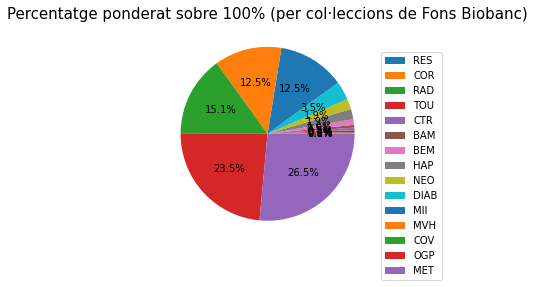

In [41]:
# Representem els percentatges de Fons Biobanc
SUMA_FBB_totals_80ºC_2['% ponderat congeladors sobre 100'] = pd.to_numeric(SUMA_FBB_totals_80ºC_2['% ponderat congeladors sobre 100'], errors='coerce')
SUMA_FBB_totals_80ºC_2 = SUMA_FBB_totals_80ºC_2.sort_values('% ponderat congeladors sobre 100')


# En pie plot:
SUMA_FBB_totals_80ºC_2['% ponderat congeladors sobre 100'].plot.pie(subplots=True,labeldistance=None,autopct='%1.1f%%',startangle = 360)
plt.title('Percentatge ponderat sobre 100% (per col·leccions de Fons Biobanc)', fontsize=15)
plt.xlabel('', fontsize=11)
plt.ylabel('',fontsize=11)
plt.legend( bbox_to_anchor=(1,0.9))
plt.show()

In [42]:
FBB_totals_TN.loc['TOTAL',:]= FBB_totals_TN.sum(axis=0)
A3_A0_totals_TN.loc['TOTAL',:]= A3_A0_totals_TN.sum(axis=0)

R20 = FBB_totals_TN.at["TOTAL", '% ocupació NL']
R179 = A3_A0_totals_TN.at["TOTAL", '% ocupació NL']
T4 = (R20+R179)

FBB_totals_TN['% ponderat NL sobre 100'] = (FBB_totals_TN['% ocupació NL']/T4)*100 
A3_A0_totals_TN['% ponderat NL sobre 100'] = (A3_A0_totals_TN['% ocupació NL']/T4)*100 

In [43]:
#FBB_totals_TN

# Per guardar el dataframe final com un Excel
# FBB_totals_TN.to_excel('FBB_totals_TN.xlsx')

# A3_A0_totals_TN

# Per guardar el dataframe final com un Excel
# A3_A0_totals_TN.to_excel('A3_A0_totals_TN.xlsx')

# FBB + A3 + A0 (TN)
# Treiem totals (última fila) per unir dataframes i obtenir el resum d'ocupació.
FBB_totals_TN_2 = FBB_totals_TN[:-1]
A3_A0_totals_TN_2 = A3_A0_totals_TN[:-1]
FBB_A3_A0_TN = pd.concat([FBB_totals_TN_2, A3_A0_totals_TN_2], axis=0)
# Extraiem les variables d'interès:
FBB_A3_A0_TN_FINAL = FBB_A3_A0_TN[['Nom col/servei','% ocupació NL']]

FBB_A3_A0_TN_FINAL
# Per guardar el dataframe final com un Excel
#FBB_A3_A0_TN.to_excel('FBB_A3_A0_TN.xlsx')

,Nom col/servei,% ocupació NL
3,BEM,0.306389
10,COV,0.719276
13,CTR,0.094875
17,HAP,0.219967
20,MET,3.591519
24,MII,0.811827
30,NEO,0.101848
33,OGP,0.982137
41,TOU,0.040148
54,LIA3-3,0.100369



## 5. RESUM 

Barreja entre Línies investigació A3, A0, FBB i ocupacions al magatzem.
Aquest resum inclou tancs de nitrogen.

### 5.1. PER TIPUS DE SUPORT

In [92]:
## FONS BIOBANC
FBB_totals2 = FBB_totals
FBB_totals2 = FBB_totals2.groupby(['Tipus suport']).sum()

# FBB - OCUPATS
RESUM_FBB_wilmut05_ocupat = FBB_totals2.at['Wilmut 0.65','Nº']
RESUM_FBB_wilmut14_ocupat = FBB_totals2.at['Wilmut 1.4','Nº']
RESUM_FBB_gradetes_ocupat = FBB_totals2.at['Gradetes','Nº']
RESUM_FBB_9x9_ocupat = FBB_totals2.at['9x9','Nº']
RESUM_FBB_tancnitrogen_ocupat = FBB_totals2.at['Tanc Nitrogen','Nº']

# FBB I LÍNIES INVESTIGACIÓ - TOTALS
RESUM_wilmut05_total = taula_resum_tipus.at['Wilmut 0.65','Totals']
RESUM_wilmut14_total = taula_resum_tipus.at['Wilmut 1.4','Totals']
RESUM_gradetes_total = taula_resum_tipus.at['Gradetes','Totals'] 
RESUM_9x9_total = taula_resum_tipus.at['9x9','Totals']
RESUM_tancnitrogen_total = TOTAL_DISPONIBLE_TANCS_NITROGEN

# TAULA
RESUM_FBB = {'SUPORT': ['Wilmut 0.65','Wilmut 1.4', 'Gradetes', '9x9', 'Tanc Nitrogen'],
        'TOTAL': [RESUM_wilmut05_total, RESUM_wilmut14_total, RESUM_gradetes_total, RESUM_9x9_total, RESUM_tancnitrogen_total],
        'OCUPAT': [RESUM_FBB_wilmut05_ocupat, RESUM_FBB_wilmut14_ocupat, RESUM_FBB_gradetes_ocupat, RESUM_FBB_9x9_ocupat, RESUM_FBB_tancnitrogen_ocupat]} 
RESUM_FBB = pd.DataFrame(RESUM_FBB)
RESUM_FBB['%'] = RESUM_FBB['OCUPAT']/RESUM_FBB['TOTAL']*100
# Posem nom a les variables.
header1=[['SUPORT','FONS BIOBANC','FONS BIOBANC','FONS BIOBANC'],
        ['SUPORT','TOTAL','OCUPAT','%']]
RESUM_FBB.columns=header1
# Canviem l'índex al suport.
RESUM_FBB = RESUM_FBB.set_index(['SUPORT'])
RESUM_FBB

# Per guardar el dataframe final com un Excel
# RESUM_FBB.to_excel('RESUM_FBB.xlsx')

FONS BIOBANC                        
                        TOTAL       OCUPAT          %
SUPORT                                               
(Wilmut 0.65,)         8865.0  5928.396160  66.874181
(Wilmut 1.4,)           505.0   384.722600  76.182693
(Gradetes,)             172.0    26.538462  15.429338
(9x9,)                 1820.0   426.226002  23.419011
(Tanc Nitrogen,)       4330.0   297.383733   6.867985

In [94]:
# LÍNIES A3 + A0
A3_A0_totals2 = A3_A0_totals
A3_A0_totals2 = A3_A0_totals2.groupby(['Tipus suport']).sum()


# LÍNIES A3+A0 - OCUPATS
RESUM_LIA3A0_wilmut05_ocupat = A3_A0_totals2.at['Wilmut 0.65','Nº']
RESUM_LIA3A0_wilmut14_ocupat = A3_A0_totals2.at['Wilmut 1.4','Nº']
RESUM_LIA3A0_gradetes_ocupat = A3_A0_totals2.at['Gradetes','Nº'] 
RESUM_LIA3A0_9x9_ocupat = A3_A0_totals2.at['9x9','Nº']
RESUM_LIA3A0_tancnitrogen_ocupat = A3_A0_totals2.at['Tanc Nitrogen','Nº']

# TAULA
RESUM_LIA3A0 = {'SUPORT': ['Wilmut 0.65','Wilmut 1.4', 'Gradetes', '9x9', 'Tanc Nitrogen'],
        'TOTAL': [RESUM_wilmut05_total, RESUM_wilmut14_total, RESUM_gradetes_total, RESUM_9x9_total, RESUM_tancnitrogen_total],
        'OCUPAT': [RESUM_LIA3A0_wilmut05_ocupat, RESUM_LIA3A0_wilmut14_ocupat, RESUM_LIA3A0_gradetes_ocupat/60, RESUM_LIA3A0_9x9_ocupat, RESUM_LIA3A0_tancnitrogen_ocupat]} 
RESUM_LIA3A0 = pd.DataFrame(RESUM_LIA3A0)
RESUM_LIA3A0['%'] = RESUM_LIA3A0['OCUPAT']/RESUM_LIA3A0['TOTAL']*100
# Posem nom a les variables.
header2=[['SUPORT','LI A3+A0','LI A3+A0','LI A3+A0'],
        ['SUPORT','TOTAL','OCUPAT','%']]
RESUM_LIA3A0.columns=header2
# Canviem l'índex al suport.
RESUM_LIA3A0 = RESUM_LIA3A0.set_index(['SUPORT'])
RESUM_LIA3A0

# Per guardar el dataframe final com un Excel
# RESUM_LIA3A0.to_excel('RESUM_LIA3A0.xlsx')

LI A3+A0                        
                    TOTAL       OCUPAT          %
SUPORT                                           
(Wilmut 0.65,)     8865.0  3338.603840  37.660506
(Wilmut 1.4,)       505.0    91.277400  18.074733
(Gradetes,)         172.0     6.291026   3.657573
(9x9,)             1820.0  1178.773998  64.767802
(Tanc Nitrogen,)   4330.0  2031.616267  46.919544

### 5.2. PER TIPUS CONGELADOR/TANC

In [95]:
# FONS BIOBANC - CONGELADORS
RESUM2_FBB_80ºC_ocupat = SUMA_FBB_totals_80ºC.at['TOTAL','% ponderat congeladors']
RESUM2_FBB_80ºC_ocupat100 = SUMA_FBB_totals_80ºC.at['TOTAL','% ponderat congeladors sobre 100']

# FONS BIOBANC - TANCS NITROGEN
RESUM2_FBB_NL_ocupat = FBB_totals_TN.at['TOTAL','% ocupació NL']
RESUM2_FBB_NL_ocupat100 = FBB_totals_TN.at['TOTAL','% ponderat NL sobre 100']

# LÍNIES A3 + A0 - CONGELADORS
RESUM2_LIA3A0_80ºC_ocupat = SUMA_A3_A0_totals_80ºC.at['TOTAL','% ponderat congeladors']
RESUM2_LIA3A0_80ºC_ocupat100 = SUMA_A3_A0_totals_80ºC.at['TOTAL','% ponderat congeladors sobre 100']

# LÍNIES A3 + A0 - TANCS NITROGEN
RESUM2_LIA3A0_NL_ocupat = A3_A0_totals_TN.at['TOTAL','% ocupació NL']
RESUM2_LIA3A0_NL_ocupat100 = A3_A0_totals_TN.at['TOTAL','% ponderat NL sobre 100']

# TAULA
RESUM_NL_FBBLIA3A0 = {'UBICACIÓ': ['FONS BIOBANC','LÍNIES INVESTIGACIÓ'],
        'TOTAL 80ºC': [RESUM2_FBB_80ºC_ocupat, RESUM2_LIA3A0_80ºC_ocupat],
        'TOTAL sobre ocupat 80ºC': [RESUM2_FBB_80ºC_ocupat100 , RESUM2_LIA3A0_80ºC_ocupat100],
        'TOTAL NL': [RESUM2_FBB_NL_ocupat, RESUM2_LIA3A0_NL_ocupat],
        'TOTAL sobre ocupat NL': [RESUM2_FBB_NL_ocupat100 , RESUM2_LIA3A0_NL_ocupat100]} 
RESUM_NL_FBBLIA3A0 = pd.DataFrame(RESUM_NL_FBBLIA3A0)
RESUM_NL_FBBLIA3A0

# Per guardar el dataframe final com un Excel
#RESUM_NL_FBBLIA3A0.to_excel('RESUM_NL_FBBLIA3A0.xlsx')

,UBICACIÓ,TOTAL 80ºC,TOTAL sobre ocupat 80ºC,TOTAL NL,TOTAL sobre ocupat NL
0,FONS BIOBANC,70.897817,43.702092,6.867985,12.76873
1,LÍNIES INVESTIGACIÓ,91.331984,56.297908,46.919544,87.23127



## 6. DISTRIBUCIÓ DE CADA CONGELADOR/TANC DE NITROGEN

### 6.1. GENERAL 

#### LÍNIA INVESTIGACIÓ - CONGELADOR/TANC - TIPUS SUPORT

Compararem el nombre de suports que cada línia d'investigació té a cada congelador o tanc de nitrogen.
S'utilitzaran els codis d'anonimització pels serveis.

In [96]:
servei_refrigerador = magatzem.groupby(['Línia A0 (anon)','Congelador/Tanc','Tipus suport']).count()
# Com surten vàries columnes al recompte, prenem una qualsevol i li canviem el nom:
servei_refrigerador = pd.DataFrame(servei_refrigerador['UBICACIO'])
servei_refrigerador.columns = ['Recompte']
servei_refrigerador

Recompte
Línia A0 (anon) Congelador/Tanc Tipus suport           
FBB             SR2             Wilmut 0.65         288
SA0-1           BB01            Wilmut 0.65          13
                DN1             Wilmut 0.65           6
                DN2             Wilmut 0.65           7
                DNM             Wilmut 1.4            9
                LOG01           Wilmut 0.65           1
                NL1             Tanc Nitrogen         1
                SR2             9x9                  77
                SR4             Wilmut 0.65         121
SA0-10          BB01            Wilmut 0.65        1025
                DN1             Wilmut 0.65         680
                DN2             Wilmut 0.65         850
                DNM             Gradetes              5
                                Wilmut 1.4          261
                LOG01           Gradetes              3
                                Wilmut 0.65           4
                                Wilmut 1.4            3
                LOG04           Gradetes             18
                                Wilmut 0.65          37
                LOG05           Gradetes             21
                NL1             Tanc Nitrogen       186
                NL2             Tanc Nitrogen       131
                NL3             Tanc Nitrogen         1
                NL4             Tanc Nitrogen        14
                NL5             Tanc Nitrogen         4
                PL1             Wilmut 0.65        1054
                                Wilmut 1.4          108
                PL2             Wilmut 0.65         768
                PRE03           Wilmut 0.65          15
                PRE04           9x9                   1
                SM1             Wilmut 0.65         624
                SM2             Wilmut 0.65        1117
                SR1+SE1         9x9                  16
                SR2             Wilmut 0.65         115
                SR3             9x9                   9
                SR4             9x9                  65
                                Wilmut 0.65          18
SA0-100         NL1             Tanc Nitrogen         4
                NL2             Tanc Nitrogen         1
                NL4             Tanc Nitrogen         4
SA0-101         NL1             Tanc Nitrogen        13
                NL4             Tanc Nitrogen         6
SA0-102         NL1             Tanc Nitrogen        12
                NL2             Tanc Nitrogen         5
                NL4             Tanc Nitrogen         6
SA0-103         NL1             Tanc Nitrogen        11
SA0-104         NL1             Tanc Nitrogen         6
                NL2             Tanc Nitrogen         1
                NL4             Tanc Nitrogen         1
SA0-105         NL1             Tanc Nitrogen         4
                NL2             Tanc Nitrogen         3
                NL4             Tanc Nitrogen         5
                NL5             Tanc Nitrogen         3
SA0-106         NL2             Tanc Nitrogen         5
SA0-107         NL1             Tanc Nitrogen         3
SA0-109         NL1             Tanc Nitrogen         2
SA0-11          DN1             Wilmut 0.65           1
SA0-110         NL1             Tanc Nitrogen         1
SA0-111         NL1             Tanc Nitrogen        16
                NL2             Tanc Nitrogen         4
                NL4             Tanc Nitrogen        15
                NL5             Tanc Nitrogen         2
SA0-112         NL1             Tanc Nitrogen         6
                NL4             Tanc Nitrogen        23
                NL5             Tanc Nitrogen         9
SA0-113         NL1             Tanc Nitrogen         3
                NL2             Tanc Nitrogen         1
                NL4             Tanc Nitrogen         1
                NL5             Tanc Nitrogen         2
SA0-114         NL1             Tanc Nitrogen         2
SA0-115        

#### CONGELADOR/TANC - LÍNIA INVESTIGACIÓ - TIPUS SUPORT

La mateixa informació ordenada per congelador/tanc de nitrogen.

In [97]:
refrigerador_servei = magatzem.groupby(['Congelador/Tanc','Línia A0 (anon)','Tipus suport']).count()
# Com surten vàries columnes al recompte, prenem una qualsevol i li canviem el nom:
refrigerador_servei = pd.DataFrame(refrigerador_servei['UBICACIO'])
refrigerador_servei.columns = ['Recompte']
refrigerador_servei

Recompte
Congelador/Tanc Línia A0 (anon) Tipus suport           
BB01            SA0-1           Wilmut 0.65          13
                SA0-10          Wilmut 0.65        1025
                SA0-14          Wilmut 0.65           1
                SA0-19          Wilmut 0.65           1
COV             SA0-21          9x9                  40
                                Gradetes              3
                                Wilmut 0.65         510
                SA0-50          9x9                   8
                SA0-53          9x9                  12
                SA0-54          9x9                   1
                SA0-64          9x9                  38
                                Gradetes              1
                SA0-67          9x9                   3
DN1             SA0-1           Wilmut 0.65           6
                SA0-10          Wilmut 0.65         680
                SA0-11          Wilmut 0.65           1
                SA0-14          Wilmut 0.65           1
                SA0-25          Wilmut 0.65           1
DN2             SA0-1           Wilmut 0.65           7
                SA0-10          Wilmut 0.65         850
                SA0-17          Wilmut 0.65           8
                SA0-19          Wilmut 0.65           1
DNM             SA0-1           Wilmut 1.4            9
                SA0-10          Gradetes              5
                                Wilmut 1.4          261
                SA0-16          Gradetes              1
                SA0-17          Gradetes              1
                                Wilmut 1.4            7
                SA0-18          Wilmut 1.4           15
                SA0-20          Wilmut 1.4            1
                SA0-33          Gradetes              3
                SA0-43          Gradetes              2
                SA0-61          Gradetes              1
                SA0-63          Gradetes              2
LOG01           SA0-1           Wilmut 0.65           1
                SA0-10          Gradetes              3
                                Wilmut 0.65           4
                                Wilmut 1.4            3
                SA0-12          Wilmut 1.4            8
                SA0-17          Gradetes              1
                SA0-18          9x9                  61
                                Wilmut 0.65          22
                SA0-24          Gradetes              2
                SA0-29          Gradetes              3
                SA0-38          9x9                   2
                SA0-41          9x9                  12
                                Gradetes              5
                SA0-45          9x9                  34
                SA0-46          9x9                  69
                SA0-5           Gradetes             25
                SA0-66          Gradetes              1
LOG03           SA0-23          9x9                   6
                SA0-26          9x9                  14
                SA0-28          9x9                  32
                                Gradetes             19
                SA0-29          9x9                  17
                SA0-3           9x9                  13
                SA0-38          9x9                   7
                SA0-42          9x9                   7
                SA0-44          9x9                   8
                SA0-45          9x9                  11
                SA0-48          9x9                  15
                SA0-52          9x9                  73
LOG04           SA0-10          Gradetes             18
                                Wilmut 0.65          37
                SA0-18          9x9                  23
                SA0-3           Wilmut 0.65         128
                SA0-38          9x9                   2
                SA0-48          9x9                  42
LOG05           SA0-10          Gradetes             21
               

### 6.2 CONGELADORS + TANCS NITROGEN (INDIVIDUALMENT)

A continuació, analitzarem el contingut a nivell de tipus de suport que té cada congelador i tanc de nitrogen. Recordo que aquesta informació prové de la base de dades Access de Magatzem.

**Comentari**

Per veure cada línia d'investigació concreta en comptes de veure-les totes agrupades (és a dir, per exemple, veure el nom complet "A0-S1800 Pep López","A0-S23232 Pepita Martínez" en comptes del grup "A0" directament), caldrà canviar la direcció del comandament 'SERVEI2' per 'SERVEI'.

### BB01

In [42]:
# Divisó per TIPUS SUPORT - SERVEI.
df_BB01 = magatzem[(magatzem['Congelador/Tanc'] == "BB01")]
recomptes_BB01 = df_BB01.groupby(['Tipus suport','SERVEI2']).count()
recomptes_BB01 = pd.DataFrame(recomptes_BB01['UBICACIO'])
recomptes_BB01.columns = ['Recompte']

# Mires els tipus de suport que hi ha.
# Llavors, anotem la capacitat màxima i el percentatge de suports ocupats.
recomptes_BB01['Capacitat màxima'] = ''
recomptes_BB01['Capacitat màxima'].loc['Wilmut 0.65'] = max_BB01_wilmut05
recomptes_BB01['% suports ocupats'] = recomptes_BB01['Recompte']/recomptes_BB01['Capacitat màxima']*100

recomptes_BB01

Recompte Capacitat màxima % suports ocupats
Tipus suport SERVEI2                                                    
Wilmut 0.65  A0                     1             1156          0.086505
             FONS BB             1038             1156         89.792388
             Serveis antics         1             1156          0.086505

### COV

In [43]:
# Divisó per TIPUS SUPORT - SERVEI.
df_COV = magatzem[(magatzem['Congelador/Tanc'] == "COV")]
recomptes_COV = df_COV.groupby(['Tipus suport','SERVEI2']).count()
recomptes_COV = pd.DataFrame(recomptes_COV['UBICACIO'])
recomptes_COV.columns = ['Recompte']

# Mires els tipus de suport que hi ha.
# Llavors, anotem la capacitat màxima i el percentatge de suports ocupats.
recomptes_COV['Capacitat màxima'] = ''
recomptes_COV['Capacitat màxima'].loc['Wilmut 0.65'] = max_COV_wilmut05
recomptes_COV['Capacitat màxima'].loc['Gradetes'] = max_COV_gradetes
recomptes_COV['Capacitat màxima'].loc['9x9'] = max_COV_9x9
recomptes_COV['% suports ocupats'] = recomptes_COV['Recompte']/recomptes_COV['Capacitat màxima']*100

recomptes_COV

Recompte Capacitat màxima % suports ocupats
Tipus suport SERVEI2                                             
9x9          A0             62              120         51.666667
             FONS BB        40              120         33.333333
Gradetes     A0              1                6         16.666667
             FONS BB         3                6              50.0
Wilmut 0.65  FONS BB       510              672         75.892857

### DN1

In [44]:
# Divisó per TIPUS SUPORT - SERVEI.
df_DN1 = magatzem[(magatzem['Congelador/Tanc'] == "DN1")]
recomptes_DN1 = df_DN1.groupby(['Tipus suport','SERVEI2']).count()
recomptes_DN1 = pd.DataFrame(recomptes_DN1['UBICACIO'])
recomptes_DN1.columns = ['Recompte']

# Mires els tipus de suport que hi ha.
# Llavors, anotem la capacitat màxima i el percentatge de suports ocupats.
recomptes_DN1['Capacitat màxima'] = ''
recomptes_DN1['Capacitat màxima'].loc['Wilmut 0.65'] = max_DN1_wilmut05
recomptes_DN1['% suports ocupats'] = recomptes_DN1['Recompte']/recomptes_DN1['Capacitat màxima']*100

recomptes_DN1

Recompte Capacitat màxima % suports ocupats
Tipus suport SERVEI2                                                    
Wilmut 0.65  A0                     1              816          0.122549
             FONS BB              687              816         84.191176
             Serveis antics         1              816          0.122549

### DN2

In [45]:
# Divisó per TIPUS SUPORT - SERVEI.
df_DN2 = magatzem[(magatzem['Congelador/Tanc'] == "DN2")]
recomptes_DN2 = df_DN2.groupby(['Tipus suport','SERVEI2']).count()
recomptes_DN2 = pd.DataFrame(recomptes_DN2['UBICACIO'])
recomptes_DN2.columns = ['Recompte']

# Mires els tipus de suport que hi ha.
# Llavors, anotem la capacitat màxima i el percentatge de suports ocupats.
recomptes_DN2['Capacitat màxima'] = ''
recomptes_DN2['Capacitat màxima'].loc['Wilmut 0.65'] = max_DN2_wilmut05
recomptes_DN2['% suports ocupats'] = recomptes_DN2['Recompte']/recomptes_DN2['Capacitat màxima']*100

recomptes_DN2

Recompte Capacitat màxima % suports ocupats
Tipus suport SERVEI2                                                    
Wilmut 0.65  A0                     1              960          0.104167
             FONS BB              857              960         89.270833
             Serveis antics         8              960          0.833333

### DNM

In [46]:
# Divisó per TIPUS SUPORT - SERVEI.
df_DNM = magatzem[(magatzem['Congelador/Tanc'] == "DNM")]
recomptes_DNM = df_DNM.groupby(['Tipus suport','SERVEI2']).count()
recomptes_DNM = pd.DataFrame(recomptes_DNM['UBICACIO'])
recomptes_DNM.columns = ['Recompte']

# Mires els tipus de suport que hi ha.
# Llavors, anotem la capacitat màxima i el percentatge de suports ocupats.
recomptes_DNM['Capacitat màxima'] = ''
recomptes_DNM['Capacitat màxima'].loc['Wilmut 1.4'] = max_DNM_wilmut14
recomptes_DNM['Capacitat màxima'].loc['Gradetes'] = max_DNM_gradetes
recomptes_DNM['% suports ocupats'] = recomptes_DNM['Recompte']/recomptes_DNM['Capacitat màxima']*100

recomptes_DNM

Recompte Capacitat màxima % suports ocupats
Tipus suport SERVEI2                                                    
Gradetes     A0                     8               15         53.333333
             FONS BB                6               15              40.0
             Serveis antics         1               15          6.666667
Wilmut 1.4   A0                    16              294          5.442177
             FONS BB              270              294         91.836735
             Serveis antics         7              294          2.380952

### LOG01

In [47]:
# Divisó per TIPUS SUPORT - SERVEI.
df_LOG01 = magatzem[(magatzem['Congelador/Tanc'] == "LOG01")]
recomptes_LOG01 = df_LOG01.groupby(['Tipus suport','SERVEI2']).count()
recomptes_LOG01 = pd.DataFrame(recomptes_LOG01['UBICACIO'])
recomptes_LOG01.columns = ['Recompte']

# Mires els tipus de suport que hi ha.
# Llavors, anotem la capacitat màxima i el percentatge de suports ocupats.
recomptes_LOG01['Capacitat màxima'] = ''
recomptes_LOG01['Capacitat màxima'].loc['Wilmut 0.65'] = max_LOG01_wilmut05
recomptes_LOG01['Capacitat màxima'].loc['Wilmut 1.4'] = max_LOG01_wilmut14
recomptes_LOG01['Capacitat màxima'].loc['Gradetes'] = max_LOG01_gradetes
recomptes_LOG01['Capacitat màxima'].loc['9x9'] = max_LOG01_9x9
recomptes_LOG01['% suports ocupats'] = recomptes_LOG01['Recompte']/recomptes_LOG01['Capacitat màxima']*100

recomptes_LOG01

Recompte Capacitat màxima % suports ocupats
Tipus suport SERVEI2                                                    
9x9          A0                   178              204         87.254902
Gradetes     A0                    30               40              75.0
             FONS BB                6               40              15.0
             Serveis antics         4               40              10.0
Wilmut 0.65  A0                    22              144         15.277778
             FONS BB                5              144          3.472222
Wilmut 1.4   FONS BB                3               12              25.0
             Serveis antics         8               12         66.666667

### LOG03

In [48]:
# Divisó per TIPUS SUPORT - SERVEI.
df_LOG03 = magatzem[(magatzem['Congelador/Tanc'] == "LOG03")]
recomptes_LOG03 = df_LOG03.groupby(['Tipus suport','SERVEI2']).count()
recomptes_LOG03 = pd.DataFrame(recomptes_LOG03['UBICACIO'])
recomptes_LOG03.columns = ['Recompte']

# Mires els tipus de suport que hi ha.
# Llavors, anotem la capacitat màxima i el percentatge de suports ocupats.
recomptes_LOG03['Capacitat màxima'] = ''
recomptes_LOG03['Capacitat màxima'].loc['Gradetes'] = max_LOG03_gradetes
recomptes_LOG03['Capacitat màxima'].loc['9x9'] = max_LOG03_9x9
recomptes_LOG03['% suports ocupats'] = recomptes_LOG03['Recompte']/recomptes_LOG03['Capacitat màxima']*100

recomptes_LOG03

Recompte Capacitat màxima % suports ocupats
Tipus suport SERVEI2                                             
9x9          A0            197              240         82.083333
             FONS BB         6              240               2.5
Gradetes     A0             19               20              95.0

### LOG04

In [49]:
# Divisó per TIPUS SUPORT - SERVEI.
df_LOG04 = magatzem[(magatzem['Congelador/Tanc'] == "LOG04")]
recomptes_LOG04 = df_LOG04.groupby(['Tipus suport','SERVEI2']).count()
recomptes_LOG04 = pd.DataFrame(recomptes_LOG04['UBICACIO'])
recomptes_LOG04.columns = ['Recompte']

# Mires els tipus de suport que hi ha.
# Llavors, anotem la capacitat màxima i el percentatge de suports ocupats.
recomptes_LOG04['Capacitat màxima'] = ''
recomptes_LOG04['Capacitat màxima'].loc['Wilmut 0.65'] = max_LOG04_wilmut05
recomptes_LOG04['Capacitat màxima'].loc['Gradetes'] = max_LOG04_gradetes
recomptes_LOG04['Capacitat màxima'].loc['9x9'] = max_LOG04_9x9
recomptes_LOG04['% suports ocupats'] = recomptes_LOG04['Recompte']/recomptes_LOG04['Capacitat màxima']*100

recomptes_LOG04

Recompte Capacitat màxima % suports ocupats
Tipus suport SERVEI2                                             
9x9          A0             67               72         93.055556
Gradetes     FONS BB        18               21         85.714286
Wilmut 0.65  A0            128              400              32.0
             FONS BB        37              400              9.25

### NL1

In [50]:
# Divisó per TIPUS SUPORT - SERVEI.
df_NL1 = magatzem[(magatzem['Congelador/Tanc'] == "NL1")]
recomptes_NL1 = df_NL1.groupby(['Tipus suport','SERVEI2']).count()
recomptes_NL1 = pd.DataFrame(recomptes_NL1['UBICACIO'])
recomptes_NL1.columns = ['Recompte']

# Mires els tipus de suport que hi ha.
# Llavors, anotem la capacitat màxima i el percentatge de suports ocupats.
recomptes_NL1['Capacitat màxima'] = ''
recomptes_NL1['Capacitat màxima'].loc['Tanc Nitrogen'] = max_NL1_tancnitrogen
recomptes_NL1['% suports ocupats'] = recomptes_NL1['Recompte']/recomptes_NL1['Capacitat màxima']*100

recomptes_NL1

Recompte Capacitat màxima % suports ocupats
Tipus suport  SERVEI2                                                    
Tanc Nitrogen A0                   530              730          72.60274
              A3                     1              730          0.136986
              FONS BB              187              730         25.616438
              Serveis antics        12              730          1.643836

### NL2

In [51]:
# Divisó per TIPUS SUPORT - SERVEI.
df_NL2 = magatzem[(magatzem['Congelador/Tanc'] == "NL2")]
recomptes_NL2 = df_NL2.groupby(['Tipus suport','SERVEI2']).count()
recomptes_NL2 = pd.DataFrame(recomptes_NL2['UBICACIO'])
recomptes_NL2.columns = ['Recompte']

# Mires els tipus de suport que hi ha.
# Llavors, anotem la capacitat màxima i el percentatge de suports ocupats.
recomptes_NL2['Capacitat màxima'] = ''
recomptes_NL2['Capacitat màxima'].loc['Tanc Nitrogen'] = max_NL2_tancnitrogen
recomptes_NL2['% suports ocupats'] = recomptes_NL2['Recompte']/recomptes_NL2['Capacitat màxima']*100

recomptes_NL2

Recompte Capacitat màxima % suports ocupats
Tipus suport  SERVEI2                                                    
Tanc Nitrogen A0                   573              720         79.583333
              A3                     1              720          0.138889
              FONS BB              131              720         18.194444
              Serveis antics        16              720          2.222222

### NL3

In [52]:
# Divisó per TIPUS SUPORT - SERVEI.
df_NL3 = magatzem[(magatzem['Congelador/Tanc'] == "NL3")]
recomptes_NL3 = df_NL3.groupby(['Tipus suport','SERVEI2']).count()
recomptes_NL3 = pd.DataFrame(recomptes_NL3['UBICACIO'])
recomptes_NL3.columns = ['Recompte']

# Mires els tipus de suport que hi ha.
# Llavors, anotem la capacitat màxima i el percentatge de suports ocupats.
recomptes_NL3['Capacitat màxima'] = ''
recomptes_NL3['Capacitat màxima'].loc['Tanc Nitrogen'] = max_NL3_tancnitrogen
recomptes_NL3['% suports ocupats'] = recomptes_NL3['Recompte']/recomptes_NL3['Capacitat màxima']*100

recomptes_NL3

Recompte Capacitat màxima % suports ocupats
Tipus suport  SERVEI2                                             
Tanc Nitrogen A0            117              720             16.25
              FONS BB         8              720          1.111111

### NL4

In [53]:
# Divisó per TIPUS SUPORT - SERVEI.
df_NL4 = magatzem[(magatzem['Congelador/Tanc'] == "NL4")]
recomptes_NL4 = df_NL4.groupby(['Tipus suport','SERVEI2']).count()
recomptes_NL4 = pd.DataFrame(recomptes_NL4['UBICACIO'])
recomptes_NL4.columns = ['Recompte']

# Mires els tipus de suport que hi ha.
# Llavors, anotem la capacitat màxima i el percentatge de suports ocupats.
recomptes_NL4['Capacitat màxima'] = ''
recomptes_NL4['Capacitat màxima'].loc['Tanc Nitrogen'] = max_NL4_tancnitrogen
recomptes_NL4['% suports ocupats'] = recomptes_NL4['Recompte']/recomptes_NL4['Capacitat màxima']*100

recomptes_NL4

Recompte Capacitat màxima % suports ocupats
Tipus suport  SERVEI2                                             
Tanc Nitrogen A0            697              720         96.805556
              FONS BB        14              720          1.944444

### NL5

In [54]:
# Divisó per TIPUS SUPORT - SERVEI.
df_NL5 = magatzem[(magatzem['Congelador/Tanc'] == "NL5")]
recomptes_NL5 = df_NL5.groupby(['Tipus suport','SERVEI2']).count()
recomptes_NL5 = pd.DataFrame(recomptes_NL5['UBICACIO'])
recomptes_NL5.columns = ['Recompte']

# Mires els tipus de suport que hi ha.
# Llavors, anotem la capacitat màxima i el percentatge de suports ocupats.
recomptes_NL5['Capacitat màxima'] = ''
recomptes_NL5['Capacitat màxima'].loc['Tanc Nitrogen'] = max_NL5_tancnitrogen
recomptes_NL5['% suports ocupats'] = recomptes_NL5['Recompte']/recomptes_NL5['Capacitat màxima']*100

recomptes_NL5

Recompte Capacitat màxima % suports ocupats
Tipus suport  SERVEI2                                             
Tanc Nitrogen A0            124              720         17.222222
              FONS BB         4              720          0.555556

### PL1

In [55]:
# Divisó per TIPUS SUPORT - SERVEI.
df_PL1 = magatzem[(magatzem['Congelador/Tanc'] == "PL1")]
recomptes_PL1 = df_PL1.groupby(['Tipus suport','SERVEI2']).count()
recomptes_PL1 = pd.DataFrame(recomptes_PL1['UBICACIO'])
recomptes_PL1.columns = ['Recompte']

# Mires els tipus de suport que hi ha.
# Llavors, anotem la capacitat màxima i el percentatge de suports ocupats.
recomptes_PL1['Capacitat màxima'] = ''
recomptes_PL1['Capacitat màxima'].loc['Wilmut 0.65'] = max_PL1_wilmut05
recomptes_PL1['Capacitat màxima'].loc['Wilmut 1.4'] = max_PL1_wilmut14
recomptes_PL1['% suports ocupats'] = recomptes_PL1['Recompte']/recomptes_PL1['Capacitat màxima']*100

recomptes_PL1

,,Recompte,Capacitat màxima,% suports ocupats
Tipus suport,SERVEI2,,,
Wilmut 0.65,FONS BB,1055,1056,99.905303
Wilmut 1.4,FONS BB,108,108,100.0


### PL2

In [56]:
# Divisó per TIPUS SUPORT - SERVEI.
df_PL2 = magatzem[(magatzem['Congelador/Tanc'] == "PL2")]
recomptes_PL2 = df_PL2.groupby(['Tipus suport','SERVEI2']).count()
recomptes_PL2 = pd.DataFrame(recomptes_PL2['UBICACIO'])
recomptes_PL2.columns = ['Recompte']

# Mires els tipus de suport que hi ha.
# Llavors, anotem la capacitat màxima i el percentatge de suports ocupats.
recomptes_PL2['Capacitat màxima'] = ''
recomptes_PL2['Capacitat màxima'].loc['Wilmut 0.65'] = max_PL2_wilmut05
recomptes_PL2['% suports ocupats'] = recomptes_PL2['Recompte']/recomptes_PL2['Capacitat màxima']*100

recomptes_PL2

,,Recompte,Capacitat màxima,% suports ocupats
Tipus suport,SERVEI2,,,
Wilmut 0.65,FONS BB,768,768,100.0


### PRE01

In [57]:
# Divisó per TIPUS SUPORT - SERVEI.
df_PRE01 = magatzem[(magatzem['Congelador/Tanc'] == "PRE01")]
recomptes_PRE01 = df_PRE01.groupby(['Tipus suport','SERVEI2']).count()
recomptes_PRE01 = pd.DataFrame(recomptes_PRE01['UBICACIO'])
recomptes_PRE01.columns = ['Recompte']

# Mires els tipus de suport que hi ha.
# Llavors, anotem la capacitat màxima i el percentatge de suports ocupats.
recomptes_PRE01['Capacitat màxima'] = ''
recomptes_PRE01['Capacitat màxima'].loc['Wilmut 0.65'] = max_PRE01_wilmut05
recomptes_PRE01['% suports ocupats'] = recomptes_PRE01['Recompte']/recomptes_PRE01['Capacitat màxima']*100

recomptes_PRE01

,,Recompte,Capacitat màxima,% suports ocupats
Tipus suport,SERVEI2,,,
Wilmut 0.65,A0,1293,1294,99.92272


### PRE02

In [58]:
# RECORDAR QUE TAMBÉ HI HA LA SAFATA DE PREDICT

# Divisó per TIPUS SUPORT - SERVEI.
df_PRE02 = magatzem[(magatzem['Congelador/Tanc'] == "PRE02")]
recomptes_PRE02 = df_PRE02.groupby(['Tipus suport','SERVEI2']).count()
recomptes_PRE02 = pd.DataFrame(recomptes_PRE02['UBICACIO'])
recomptes_PRE02.columns = ['Recompte']


# Mires els tipus de suport que hi ha.
# Llavors, anotem la capacitat màxima i el percentatge de suports ocupats.
recomptes_PRE02['Capacitat màxima'] = ''
recomptes_PRE02['Capacitat màxima'].loc['Gradetes'] = max_PRE02_gradetes
recomptes_PRE02['Capacitat màxima'].loc['9x9'] = max_PRE02_9x9
recomptes_PRE02['% suports ocupats'] = recomptes_PRE02['Recompte']/recomptes_PRE02['Capacitat màxima']*100

recomptes_PRE02

,,Recompte,Capacitat màxima,% suports ocupats
Tipus suport,SERVEI2,,,
9x9,A0,16,416,3.846154
Gradetes,A0,156,148,105.405405


### PRE03

In [59]:
# Divisó per TIPUS SUPORT - SERVEI.
df_PRE03 = magatzem[(magatzem['Congelador/Tanc'] == "PRE03")]
recomptes_PRE03 = df_PRE03.groupby(['Tipus suport','SERVEI2']).count()
recomptes_PRE03 = pd.DataFrame(recomptes_PRE03['UBICACIO'])
recomptes_PRE03.columns = ['Recompte']

# Mires els tipus de suport que hi ha.
# Llavors, anotem la capacitat màxima i el percentatge de suports ocupats.
recomptes_PRE03['Capacitat màxima'] = ''
recomptes_PRE03['Capacitat màxima'].loc['Wilmut 0.65'] = max_PRE03_wilmut05
recomptes_PRE03['Capacitat màxima'].loc['Gradetes'] = max_PRE03_gradetes
recomptes_PRE03['% suports ocupats'] = recomptes_PRE03['Recompte']/recomptes_PRE03['Capacitat màxima']*100

recomptes_PRE03

Recompte Capacitat màxima % suports ocupats
Tipus suport SERVEI2                                             
Gradetes     A0             64               70         91.428571
Wilmut 0.65  A0            511              816         62.622549
             FONS BB        15              816          1.838235

### PRE04

In [60]:
# Divisó per TIPUS SUPORT - SERVEI.
df_PRE04 = magatzem[(magatzem['Congelador/Tanc'] == "PRE04")]
recomptes_PRE04 = df_PRE04.groupby(['Tipus suport','SERVEI2']).count()
recomptes_PRE04 = pd.DataFrame(recomptes_PRE04['UBICACIO'])
recomptes_PRE04.columns = ['Recompte']

# Mires els tipus de suport que hi ha.
# Llavors, anotem la capacitat màxima i el percentatge de suports ocupats.
recomptes_PRE04['Capacitat màxima'] = ''
recomptes_PRE04['Capacitat màxima'].loc['9x9'] = max_PRE04_9x9
recomptes_PRE04['Capacitat màxima'].loc['Gradetes'] = max_PRE04_gradetes
recomptes_PRE04['% suports ocupats'] = recomptes_PRE04['Recompte']/recomptes_PRE04['Capacitat màxima']*100

recomptes_PRE04

Recompte Capacitat màxima % suports ocupats
Tipus suport SERVEI2                                             
9x9          A0             79               80             98.75
             FONS BB         1               80              1.25
Gradetes     A0             77               83         92.771084

### SM1

In [61]:
# Divisó per TIPUS SUPORT - SERVEI.
df_SM1 = magatzem[(magatzem['Congelador/Tanc'] == "SM1")]
recomptes_SM1 = df_SM1.groupby(['Tipus suport','SERVEI2']).count()
recomptes_SM1 = pd.DataFrame(recomptes_SM1['UBICACIO'])
recomptes_SM1.columns = ['Recompte']

# Mires els tipus de suport que hi ha.
# Llavors, anotem la capacitat màxima i el percentatge de suports ocupats.
recomptes_SM1['Capacitat màxima'] = ''
recomptes_SM1['Capacitat màxima'].loc['Wilmut 0.65'] = max_SM1_wilmut05
recomptes_SM1['% suports ocupats'] = recomptes_SM1['Recompte']/recomptes_SM1['Capacitat màxima']*100

recomptes_SM1

,,Recompte,Capacitat màxima,% suports ocupats
Tipus suport,SERVEI2,,,
Wilmut 0.65,FONS BB,624,624,100.0


### SM2

In [62]:
# Divisó per TIPUS SUPORT - SERVEI.
df_SM2 = magatzem[(magatzem['Congelador/Tanc'] == "SM2")]
recomptes_SM2 = df_SM1.groupby(['Tipus suport','SERVEI2']).count()
recomptes_SM2 = pd.DataFrame(recomptes_SM2['UBICACIO'])
recomptes_SM2.columns = ['Recompte']

# Mires els tipus de suport que hi ha.
# Llavors, anotem la capacitat màxima i el percentatge de suports ocupats.
recomptes_SM2['Capacitat màxima'] = ''
recomptes_SM2['Capacitat màxima'].loc['Wilmut 0.65'] = max_SM2_wilmut05
recomptes_SM2['% suports ocupats'] = recomptes_SM2['Recompte']/recomptes_SM2['Capacitat màxima']*100

recomptes_SM2

,,Recompte,Capacitat màxima,% suports ocupats
Tipus suport,SERVEI2,,,
Wilmut 0.65,FONS BB,624,1152,54.166667


### SR1+SE1

In [63]:
# Divisó per TIPUS SUPORT - SERVEI.
df_SR1SE1 = magatzem[(magatzem['Congelador/Tanc'] == "SR1+SE1")]
recomptes_SR1SE1 = df_SR1SE1.groupby(['Tipus suport','SERVEI2']).count()
recomptes_SR1SE1 = pd.DataFrame(recomptes_SR1SE1['UBICACIO'])
recomptes_SR1SE1.columns = ['Recompte']

# Mires els tipus de suport que hi ha.
# Llavors, anotem la capacitat màxima i el percentatge de suports ocupats.
recomptes_SR1SE1['Capacitat màxima'] = ''
recomptes_SR1SE1['Capacitat màxima'].loc['Wilmut 0.65'] = max_SR1SE1_wilmut05
recomptes_SR1SE1['Capacitat màxima'].loc['Wilmut 1.4'] = max_SR1SE1_wilmut14
recomptes_SR1SE1['Capacitat màxima'].loc['9x9'] = max_SR1SE1_9x9
recomptes_SR1SE1['% suports ocupats'] = recomptes_SR1SE1['Recompte']/recomptes_SR1SE1['Capacitat màxima']*100

recomptes_SR1SE1

Recompte Capacitat màxima % suports ocupats
Tipus suport SERVEI2                                                    
9x9          A0                   171              416         41.105769
             A3                     1              416          0.240385
             FONS BB              186              416         44.711538
             Serveis antics         7              416          1.682692
Wilmut 0.65  A0                     8                9         88.888889
             FONS BB                1                9         11.111111
Wilmut 1.4   A0                    43               91         47.252747
             FONS BB               36               91          39.56044

### SR2

In [64]:
# Divisó per TIPUS SUPORT - SERVEI.
df_SR2 = magatzem[(magatzem['Congelador/Tanc'] == "SR2")]
recomptes_SR2 = df_SR2.groupby(['Tipus suport','SERVEI2']).count()
recomptes_SR2 = pd.DataFrame(recomptes_SR2['UBICACIO'])
recomptes_SR2.columns = ['Recompte']

# Mires els tipus de suport que hi ha.
# Llavors, anotem la capacitat màxima i el percentatge de suports ocupats.
recomptes_SR2['Capacitat màxima'] = ''
recomptes_SR2['Capacitat màxima'].loc['Wilmut 0.65'] = max_SR2_wilmut05
recomptes_SR2['Capacitat màxima'].loc['9x9'] = max_SR2_9x9
recomptes_SR2['% suports ocupats'] = recomptes_SR2['Recompte']/recomptes_SR2['Capacitat màxima']*100

recomptes_SR2

Recompte Capacitat màxima % suports ocupats
Tipus suport SERVEI2                                                    
9x9          A0                     1               80              1.25
             FONS BB               77               80             96.25
Wilmut 0.65  FONS BB              403              600         67.166667
             Serveis antics         2              600          0.333333

### SR3

In [65]:
# Divisó per TIPUS SUPORT - SERVEI.
df_SR3 = magatzem[(magatzem['Congelador/Tanc'] == "SR3")]
recomptes_SR3 = df_SR2.groupby(['Tipus suport','SERVEI2']).count()
recomptes_SR3 = pd.DataFrame(recomptes_SR3['UBICACIO'])
recomptes_SR3.columns = ['Recompte']

# Mires els tipus de suport que hi ha.
# Llavors, anotem la capacitat màxima i el percentatge de suports ocupats.
recomptes_SR3['Capacitat màxima'] = ''
recomptes_SR3['Capacitat màxima'].loc['Wilmut 0.65'] = max_SR3_wilmut05
recomptes_SR3['Capacitat màxima'].loc['9x9'] = max_SR3_9x9
recomptes_SR3['% suports ocupats'] = recomptes_SR3['Recompte']/recomptes_SR3['Capacitat màxima']*100

recomptes_SR3

Recompte Capacitat màxima % suports ocupats
Tipus suport SERVEI2                                                    
9x9          A0                     1              404          0.247525
             FONS BB               77              404         19.059406
Wilmut 0.65  FONS BB              403              118        341.525424
             Serveis antics         2              118          1.694915

### SR4

In [66]:
# Divisó per TIPUS SUPORT - SERVEI.
df_SR4 = magatzem[(magatzem['Congelador/Tanc'] == "SR4")]
recomptes_SR4 = df_SR4.groupby(['Tipus suport','SERVEI2']).count()
recomptes_SR4 = pd.DataFrame(recomptes_SR4['UBICACIO'])
recomptes_SR4.columns = ['Recompte']

# Mires els tipus de suport que hi ha.
# Llavors, anotem la capacitat màxima i el percentatge de suports ocupats.
recomptes_SR4['Capacitat màxima'] = ''
recomptes_SR4['Capacitat màxima'].loc['Wilmut 0.65'] = max_SR4_wilmut05
recomptes_SR4['Capacitat màxima'].loc['Gradetes'] = max_SR4_gradetes
recomptes_SR4['Capacitat màxima'].loc['9x9'] = max_SR4_9x9
recomptes_SR4['% suports ocupats'] = recomptes_SR4['Recompte']/recomptes_SR4['Capacitat màxima']*100

recomptes_SR4

Recompte Capacitat màxima % suports ocupats
Tipus suport SERVEI2                                             
9x9          A0             67              200              33.5
             FONS BB        65              200              32.5
Gradetes     A0             25               28         89.285714
Wilmut 0.65  FONS BB       139              390         35.641026